# Customer segmentation
_F. Daniel (September 2017)_

Improved (2020) by Juno Wen, Jenny Shang, Kefan Lu, Donny Yang, Yura Shakhnazarian, Rachel Yan, Andrew Zhao, Lingrou Wang
____

This notebook aims at analyzing the content of an E-commerce database that lists purchases made by $\sim$4000 customers over a period of one year (from 2010/12/01 to 2011/12/09). Based on this analysis, I develop a model that allows to anticipate the purchases that will be made by a new customer, during the following year and this, from its first purchase. <br>

___
**Acknowledgement**: many thanks to [J. Abécassis](https://www.kaggle.com/judithabk6) for advice and help provided during the writing of this notebook 
___
**1. Data Preparation**

**2. Exploring the content of variables**

   - 2.1 Countries
   - 2.2 Customers and products
       * 2.2.1 Cancelling orders
       * 2.2.2 StockCode
       * 2.2.3 Basket price

**3.Product segmentation using clustering**

   - 3.1 Product description 
   - 3.2 Defining product categories 
       * 3.2.1 Data encoding
       * 3.2.2 Clusters of products
       * 3.2.3 Characterizing the content of clusters
   
**4. Customer segmentation using clustering**

   - 4.1 Formating data
       * 4.1.1 Grouping products 
       * 4.1.2 Time spliting of the dataset
       * 4.1.3 Grouping orders 
   - 4.2 Creating customer categories
       * 4.2.1 Data enconding
       * 4.2.2 Creating categories

**5. Models to predict customer segments based on early usage**

   - 5.1 Support Vector Machine Classifier (SVC)
       * 5.1.1 Confusion matrix
       * 5.1.2 Leraning curves 
   - 5.2 Logistic regression 
   - 5.3 k-Nearest Neighbors
   - 5.4 Decision Tree
   - 5.5 Random Forest
   - 5.6 AdaBoost
   - 5.7 Gradient Boosting Classifier
   - 5.8 Let's vote !
   
**6. Testing the predictions**

**7. Conclusion**

## 1. Data preparation

As a first step, I load all the modules that will be used in this notebook:

In [1]:
import pandas as pd
from datetime import datetime
start_time = datetime.now()

# need to install these libraries the first time you run the notebook
# %pip install --user -U nltk
# %conda install -c conda-forge wordcloud
# %conda install -c plotly plotly
# %pip install pandas-profiling
# %pip install mlxtend
# %pip install surprise
# %pip install spotlight
# %pip install scipy == 1.1.0
# %pip install lifetimes

#Because of issues with pandas profiling versions when installed using pip/conda, this code is run to resolve it
# %pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
    
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk.corpus import stopwords
from lifetimes import BetaGeoFitter
from scipy.special import logsumexp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.cm as cm
import itertools
# import pandas_profiling
import plotly.graph_objs as go
import math

# from spotlight.interactions import Interactions
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from scipy.spatial.distance import cdist
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
from datetime import datetime
from plotly.offline import init_notebook_mode,iplot
from sklearn.manifold import TSNE
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
# plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline
print('LOAD TIME: ',datetime.now() - start_time) # Load duration about 2 minutes

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


LOAD TIME:  0:00:06.032700


Then, I load the data. Once done, I also give some basic informations on the content of the dataframe: the type of the various fields, the number of null values and their percentage with respect to the total number of entries:

In [2]:
#__________________
# read the datafile
df_initial = pd.read_csv('data.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})
print('Dataframe dimensions:', df_initial.shape)
#______
df_initial['InvoiceDate'] = pd.to_datetime(df_initial['InvoiceDate'])
#____________________________________________________________
# gives some info on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)
#__________________
# show first lines
display(df_initial[:5])

Dataframe dimensions: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,1454,0,0,0,135080,0
null values (%),0,0,0.268311,0,0,0,24.9267,0


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [3]:
df_initial.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [4]:
# Output a profile of the original, raw data
# profile = pandas_profiling.ProfileReport(df_initial)
# profile.to_file('Initial data profile.html')

While looking at the number of null values in the dataframe, it is interesting to note that $\sim$25% of the entries are not assigned to a particular customer. With the data available, it is impossible to impute values for the user and these entries are thus useless for the current exercise. So I delete them from the dataframe:

### from Jenny Shang
This is a lot of orders to just drop/ignore. Before deleting the entries that are not assigned to a particular customer, it is worth taking a look at these entries and explore reasons on why they are not associated with any customers.

In [5]:
## Look at entries with no customer ID

no_cust = df_initial[df_initial["CustomerID"].isnull() == True]
no_cust.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom


In [6]:
no_cust.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom
541540,581498,DOT,DOTCOM POSTAGE,1,2011-12-09 10:26:00,1714.17,NaN,United Kingdom


In [7]:
no_cust["Country"].value_counts()

United Kingdom    133600
EIRE                 711
Hong Kong            288
Unspecified          202
Switzerland          125
France                66
Israel                47
Portugal              39
Bahrain                2
Name: Country, dtype: int64

From the exploration, although there is no particular invoice or product associated with no Customer ID, majority of the entry is from the UK. I think dropping the entries without investigating is a rushed decision because one possible reason that these entries don't have an associated Customer ID is because the customer is a new customer (i.e. not assigned an ID yet). I think a more reasonable choice would be to assign an independent Customer ID such as the InvoiceNo (since items with the same InvoiceNo would be assumed to be purchased by the same customer).

In [8]:
## Check to make sure that the CustomerIDs don't go as high as the InvoiceNo.

pd.DataFrame(df_initial["CustomerID"].value_counts().reset_index().sort_values(by = "index",ascending = False))

,index,CustomerID
1532,18287,70
31,18283,756
3550,18282,13
3976,18281,7
3763,18280,10
...,...,...
3306,12350,17
1472,12349,73
2532,12348,31
526,12347,182


In [9]:
pd.DataFrame(df_initial["InvoiceNo"].value_counts().reset_index().sort_values(by = "index",ascending = False))

,index,InvoiceNo
19046,C581569,2
20734,C581568,1
21565,C581499,1
19630,C581490,2
23753,C581484,1
...,...,...
21018,536369,1
16931,536368,4
11777,536367,12
19489,536366,2


## Two choice of what to do with the orders with no Customer number. Use one or the other below:

In [10]:
# 1. replace the empty Customer IDs with a unique number, the invoice number
# df_initial["CustomerID"] = df_initial["CustomerID"].fillna(df_initial.InvoiceNo)
# print('Dataframe dimensions:', df_initial.shape)

In [11]:
# or, 2. alternatively, just drop the orders with no customer ID
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)

Dataframe dimensions: (406829, 8)


In [12]:
df_initial.dropna(axis = 0, subset = ['CustomerID'], inplace = True)
print('Dataframe dimensions:', df_initial.shape)
#____________________________________________________________
# gives some info on columns types and numer of null values
tab_info=pd.DataFrame(df_initial.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df_initial.isnull().sum()/df_initial.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

Dataframe dimensions: (406829, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
column type,object,object,object,int64,datetime64[ns],float64,object,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0,0,0,0,0,0,0,0


OK, therefore, by removing these entries we end up with a dataframe filled at 100% for all variables! Finally, I check for duplicate entries and delete them:

In [13]:
# drop duplicate entries. Is this the right thing to do?
print('Duplicate entries: {}'.format(df_initial.duplicated().sum()))
df_initial.drop_duplicates(inplace = True)

Duplicate entries: 5225


___
## 2. Exploring the content of fieldss

This dataframe contains 8 fields that correspond to: 

**InvoiceNo**: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.  <br>
**StockCode**: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product. <br>
**Description**: Product (item) name. Nominal. <br>
**Quantity**: The quantities of each product (item) per transaction. Numeric.	<br>
**InvoiceDate**: Invice Date and time. Numeric, the day and time when each transaction was generated. <br>
**UnitPrice**: Unit price. Numeric, Product price per unit in sterling. <br>
**CustomerID**: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer. <br>
**Country**: Country name. Nominal, the name of the country where each customer resides.<br>

___
### 2.0 Field Statistics

For numeric fields, I look at the distribution of values. For categorical fields, look at the top 15 most occurring values. 

In [14]:
## 1. InvoiceNo. - who made the biggest orders

df_initial["InvoiceNo"].value_counts()

576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
C560408      1
553466       1
546462       1
C538695      1
C554541      1
Name: InvoiceNo, Length: 22190, dtype: int64

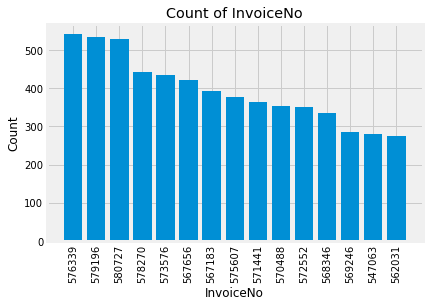

In [15]:
plt.figure()

temp = pd.DataFrame(df_initial["InvoiceNo"].value_counts())

plt.bar(temp.index[:15], temp.InvoiceNo[:15])
plt.xticks(rotation = 90)
plt.xlabel("InvoiceNo")
plt.ylabel("Count")
plt.title("Count of InvoiceNo")

plt.show()

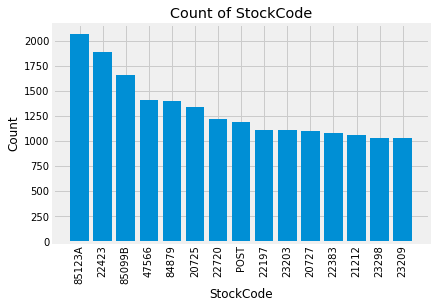

In [16]:
## StockCode

plt.figure()

temp = pd.DataFrame(df_initial["StockCode"].value_counts())

plt.bar(temp.index[:15], temp.StockCode[:15])
plt.xticks(rotation = 90)
plt.xlabel("StockCode")
plt.ylabel("Count")
plt.title("Count of StockCode")

plt.show()

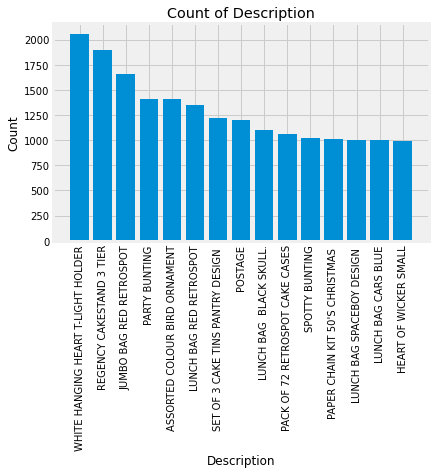

In [17]:
## 3. Description

plt.figure()

temp = pd.DataFrame(df_initial["Description"].value_counts())

plt.bar(temp.index[:15], temp.Description[:15])
plt.xticks(rotation = 90)
plt.xlabel("Description")
plt.ylabel("Count")
plt.title("Count of Description")

plt.show()

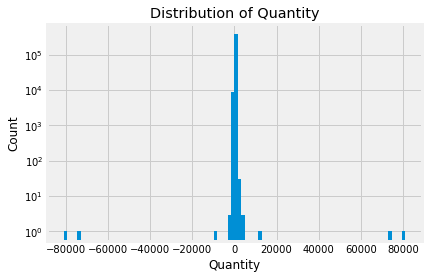

In [18]:
## 4. Quantity

plt.figure()

plt.hist(df_initial["Quantity"], bins = 100)
plt.yscale("log")
plt.xlabel("Quantity")
plt.ylabel("Count")
plt.title("Distribution of Quantity")

plt.show()

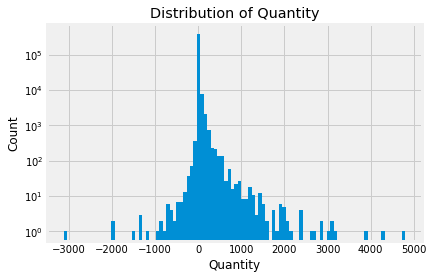

In [19]:
## Zoom in on the area between -5000 to 5000
temp = df_initial[(df_initial["Quantity"]<5000) & (df_initial["Quantity"]>-5000)]

plt.figure()

plt.hist(temp["Quantity"], bins = 100)
plt.yscale("log")
plt.xlabel("Quantity")
plt.ylabel("Count")
plt.title("Distribution of Quantity")

plt.show()

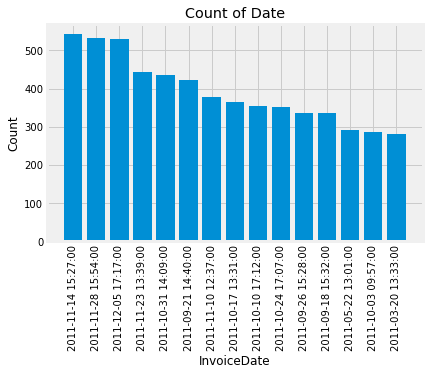

In [20]:
## 5. InvoiceDate

plt.figure()

temp = pd.DataFrame(df_initial["InvoiceDate"].value_counts()).reset_index()

plt.bar(temp["index"][:15].astype(str), temp.InvoiceDate[:15])
plt.xticks(rotation = 90)
plt.xlabel("InvoiceDate")
plt.ylabel("Count")
plt.title("Count of Date")

plt.show()

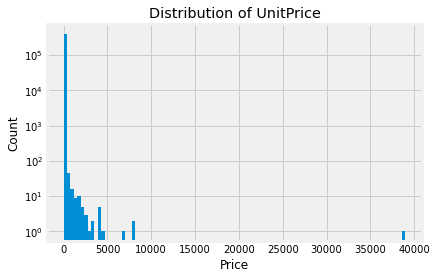

In [21]:
## 6. UnitPrice

plt.figure()

plt.hist(df_initial["UnitPrice"], bins = 100)
#plt.xticks(rotation = 90)
#plt.xlim(-200,200)
plt.yscale("log")
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of UnitPrice")

plt.show()

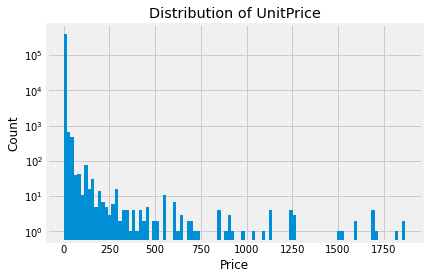

In [22]:
## Zoom in on the area between 0 to 2000
temp = df_initial[(df_initial["UnitPrice"]<2000) & (df_initial["UnitPrice"]>0)]

plt.figure()

plt.hist(temp["UnitPrice"], bins = 100)
plt.yscale("log")
plt.xlabel("Price")
plt.ylabel("Count")
plt.title("Distribution of UnitPrice")

plt.show()

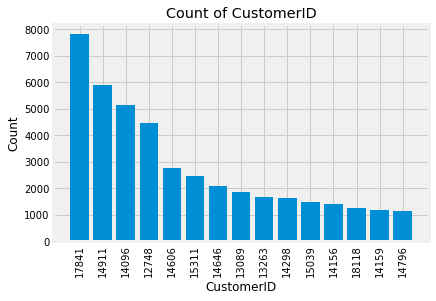

In [23]:
## 7. CustomerID

plt.figure()

temp = pd.DataFrame(df_initial["CustomerID"].value_counts())

plt.bar(temp.index[:15], temp.CustomerID[:15])
plt.xticks(rotation = 90)
plt.xlabel("CustomerID")
plt.ylabel("Count")
plt.title("Count of CustomerID")

plt.show()

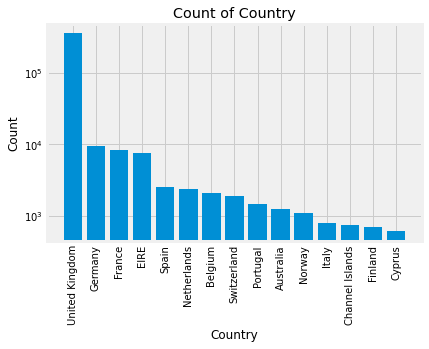

In [24]:
## 8. Country

plt.figure()

temp = pd.DataFrame(df_initial["Country"].value_counts())

plt.bar(temp.index[:15], temp.Country[:15])
plt.yscale("log")
plt.xticks(rotation = 90)
plt.xlabel("Country")
plt.ylabel("Count")
plt.title("Count of Country")

plt.show()

### 2.1 Countries

Here, I quickly look at the countries from which orders were made:

In [25]:
temp = df_initial[['CustomerID', 'InvoiceNo', 'Country']].groupby(['CustomerID', 'InvoiceNo', 'Country']).count()
temp = temp.reset_index(drop = False)
countries = temp['Country'].value_counts()
print('Number of countries in the data: {}'.format(len(countries)))

Number of countries in the data: 37


and show the result on a chloropleth map:

In [26]:
data = dict(type='choropleth',
locations = countries.index,
locationmode = 'country names', z = countries,
text = countries.index, colorbar = {'title':'Order nb.'},
colorscale=[[0, 'rgb(224,255,255)'],
            [0.01, 'rgb(166,206,227)'], [0.02, 'rgb(31,120,180)'],
            [0.03, 'rgb(178,223,138)'], [0.05, 'rgb(51,160,44)'],
            [0.10, 'rgb(251,154,153)'], [0.20, 'rgb(255,255,0)'],
            [1, 'rgb(227,26,28)']],    
reversescale = False)
#_______________________
layout = dict(title='Number of orders per country',
geo = dict(showframe = True, projection={'type':'mercator'}))
#______________
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate=False)

In [27]:
# I also explored which countries accounted for the most unique customers
forhist = temp.groupby('Country')['CustomerID'].nunique().reset_index().sort_values('CustomerID', ascending = False)
forhist.reset_index(inplace = True)
forhist.drop('index', axis = 1, inplace = True)
display(forhist.head(10))

,Country,CustomerID
0,United Kingdom,3950
1,Germany,95
2,France,87
3,Spain,31
4,Belgium,25
5,Switzerland,21
6,Portugal,19
7,Italy,15
8,Finland,12
9,Austria,11


We see that the dataset is largely dominated by orders made from the UK.

___
### 2.2 Customers and products

The dataframe contains $\sim$400,000 entries. What are the number of users and products in these entries ?

In [28]:
# String to be searched in start of string  
search ="C"
  
# boolean series returned 
df_initial[df_initial["InvoiceNo"].str.startswith(search)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315,United Kingdom


In [29]:
pd.DataFrame([{'products': len(df_initial['StockCode'].value_counts()),    
               'transactions': len(df_initial['InvoiceNo'].value_counts()),
               'customers': len(df_initial['CustomerID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,3684,22190,4372


It can be seen that the data has 4372 users and that they bought 3684 different products. The total number of transactions carried out is of the order of $\sim$22'000.

Now I will determine the number of products purchased in every transaction:

In [30]:
temp = df_initial.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
nb_products_per_basket = temp.rename(columns = {'InvoiceDate':'Number of products'})
nb_products_per_basket[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24
5,12347,556201,18
6,12347,562032,22
7,12347,573511,47
8,12347,581180,11
9,12348,539318,17


The first lines of this list shows several things worthy of interest:
- the existence of entries with the prefix C for the **InvoiceNo** variable: this indicates transactions that have been canceled
- the existence of users who only came once and only purchased one product (e.g. nº12346)
- the existence of frequent users that buy a large number of items at each order

___
#### 2.2.1 Canceled orders

First of all, I count the number of transactions corresponding to canceled orders:

In [31]:
nb_products_per_basket['order_canceled'] = nb_products_per_basket['InvoiceNo'].apply(lambda x:int('C' in x))
display(nb_products_per_basket[:5])
#______________________________________________________________________________________________
n1 = nb_products_per_basket['order_canceled'].sum()
n2 = nb_products_per_basket.shape[0]
print('Number of cancellation transactions among all orders: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

,CustomerID,InvoiceNo,Number of products,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of cancellation transactions among all orders: 3654/22190 (16.47%) 


We note that the number of cancellations is quite large ($\sim$16% of the total number of transactions).
Now, let's look at the first lines of the dataframe:

In [32]:
display(df_initial.sort_values('CustomerID')[:5])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347,Iceland


On these few lines, we see that when an order is canceled, we have another transaction in the dataframe, mostly identical except for the **Quantity** and **InvoiceDate** variables. I decide to check if this is true for all the entries.
To do this, I decide to locate the entries that indicate a negative quantity and check if there is *systematically* an order indicating the same quantity (but positive), with the same description (**CustomerID**, **Description** and **UnitPrice**):

In [33]:
df_check = df_initial[df_initial['Quantity'] < 0][['CustomerID','Quantity',
                                                   'StockCode','Description','UnitPrice']]
for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

CustomerID        14527
Quantity             -1
StockCode             D
Description    Discount
UnitPrice          27.5
Name: 141, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


We see that the initial hypothesis is not fulfilled because of the existence of a  '_Discount_' entry. I check again the hypothesis but this time discarding the '_Discount_' entries:

In [34]:
df_check = df_initial[(df_initial['Quantity'] < 0) & (df_initial['Description'] != 'Discount')][
                                 ['CustomerID','Quantity','StockCode',
                                  'Description','UnitPrice']]

for index, col in  df_check.iterrows():
    if df_initial[(df_initial['CustomerID'] == col[0]) & (df_initial['Quantity'] == -col[1]) 
                & (df_initial['Description'] == col[2])].shape[0] == 0: 
        print(index, df_check.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS NOT FULFILLED')
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
---------------> HYPOTHESIS NOT FULFILLED


Once more, we find that the initial hypothesis is not verified. Hence, cancellations do not necessarily correspond to orders that would have been made beforehand.

At this point, I decide to create a new field in the dataframe that indicates if part of the order has been canceled. For the cancellations without counterparts, a few of them are probably due to the fact that the buy orders were performed before December 2010 (the point of entry of the database). Below, I make a census of the canceled orders and check for the existence of counterparts:

In [35]:
# try to match all cancellation orders with all previous purchase orders
cancels=df_initial[(df_initial['Description']!='Discount')&(df_initial['Quantity']<0)].copy()
cancels['cancel_idx']=cancels.index
df_match=df_initial.copy()
df_match['match_idx']=df_match.index
df_match=df_match[df_match['Quantity']>0]
mg=cancels.merge(df_match[['InvoiceDate','CustomerID','StockCode','Quantity','match_idx']],how='left',
              left_on=['CustomerID','StockCode'],right_on=['CustomerID','StockCode'])
matched=mg[mg['InvoiceDate_x']>mg['InvoiceDate_y']]
matched['match_idx']=matched['match_idx'].astype(int)
matched['Quantity_y']=matched['Quantity_y'].astype(int)
# sort data to make sure matching starts with the latest purchase order
matched=matched.sort_values(['cancel_idx','InvoiceDate_y'],ascending=[1,0])

In [36]:
# since one purchase order can be matched to multiple cancellation orders,
# it can happen that one purchase order is accounted for too many cancellation orders
# e.g. the purchase order only listed 8 units in quantity, 
# but is used to match multiple cancallation orders of which the quantities sum up to more than 8
# in other words, this purchase order is double counted
# the following codes handle this problem
count=1
while True:
    # if a customer returns items that were bought through multiple purchases
    # start accounts for the returned quantity from the latest order
    # until all returned/canceled quantity is accounted for and linked to a purchase order
    # it is possible that not all the canceled quantity can be accounted for
    matched['tot_bought']=matched.groupby('cancel_idx')['Quantity_y'].cumsum()
    matched['tot_bought_lag1']=matched.groupby('cancel_idx')['tot_bought'].shift(1).fillna(0)
    matched['QuantityCanceled']=matched[['Quantity_x','Quantity_y','tot_bought','tot_bought_lag1']].\
                                 apply(lambda x: min(-x[0],x[1]) if x[3]==0 else \
                                       (x[1] if x[2]<=-x[0] else \
                                       (0 if x[3]>=-x[0] else -x[0]-x[3])), axis=1).astype(int)
    # add a column to track the total quantity a given purchae order has been used to account for a cancellation
    # if the total quantity counted exceeds the number of units that were bought in this order
    # remove this purchase order from the candidate lists of all cancellation orders from this point on
    # iterate one more time to link cancellations to purchases
    matched['tot_QuantityCanceled']=matched.groupby('match_idx')['QuantityCanceled'].cumsum()
    double_count=len(matched[matched['tot_QuantityCanceled']>matched['Quantity_y']])
    print('Iteration {} double counted: {} times'.format(count, double_count))
    if double_count>0:
        matched=matched[matched['tot_QuantityCanceled']<=matched['Quantity_y']]
        count+=1
    else:
        print('End iteration')
        break

Iteration 1 double counted: 96 times
Iteration 2 double counted: 10 times
Iteration 3 double counted: 4 times
Iteration 4 double counted: 3 times
Iteration 5 double counted: 2 times
Iteration 6 double counted: 0 times
End iteration


In [37]:
tot_canceled=matched.groupby('cancel_idx')['Quantity_x'].mean()*(-1)
tot_bought=matched.groupby('cancel_idx')['Quantity_y'].sum()
# some but not all units of the cancellation are accounted for and linked to purchase orders
partial_doubtful_entry=tot_canceled[tot_canceled>tot_bought].index.tolist()
# all units of the cancellation are accounted for and linked to purchase orders
entry_to_remove=tot_canceled[tot_canceled<=tot_bought].index.tolist()
# no previous purchase that match the cancellation can be found
doubtful_entry=list(set(mg['cancel_idx'].unique())-set(partial_doubtful_entry)-set(entry_to_remove))

In [38]:
df_cleaned = df_initial.copy(deep = True)
df_cleaned=df_cleaned.merge(pd.DataFrame(matched[['match_idx','tot_QuantityCanceled']].groupby('match_idx').max()),
                            how='left',left_index=True, right_index=True)
df_cleaned.rename(columns={'tot_QuantityCanceled':'QuantityCanceled'},inplace=True)
df_cleaned['QuantityCanceled']=df_cleaned['QuantityCanceled'].fillna(0).astype(int)

In [39]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0


In [40]:
print(f"Entry_to_remove: {len(entry_to_remove)} ({len(entry_to_remove)/len(df_initial)*100:.2f}%)")
print(f"Doubtful_entry: {len(doubtful_entry)} ({len(doubtful_entry)/len(df_initial)*100:.2f}%)")
print(f"Partial_doubtful_entry: {len(partial_doubtful_entry)} ({len(partial_doubtful_entry)/len(df_initial)*100:.2f}%)")

Entry_to_remove: 7476 (1.86%)
Doubtful_entry: 1267 (0.32%)
Partial_doubtful_entry: 52 (0.01%)


Among all the cancellation entries, the lines listed in the `entry_to_remove` list are the cancellation orders in which all the units canceled are fully accounted for. The lines listed in the `doubtful_entry` list correspond to the cancellations that no matching purchase order beforehand can be found. The lines listed in the ` partial_doubtful_entry` list represent cancellation orders in which the units canceled are partially accounted. In practice, I decide to delete all of these entries, which count respectively for  $\sim$1.9%, 0.3% and 0.01% of the dataframe entries.

Now all transactions that are not discount but have negative quantities have been removed.

In [41]:
df_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
df_cleaned.drop(doubtful_entry, axis = 0, inplace = True)
df_cleaned.drop(partial_doubtful_entry, axis = 0, inplace = True)
remaining_entries = df_cleaned[(df_cleaned['Quantity'] < 0) & (df_cleaned['StockCode'] != 'D')]
print("number of entries to delete: {}".format(remaining_entries.shape[0]))

number of entries to delete: 0


We see that the quantity canceled is greater than the sum of the previous purchases.

In [42]:
# # Output a profile of the cleaned data
# profile = pandas_profiling.ProfileReport(df_cleaned)
# profile.to_file('Cleaned data profile.html')

In [43]:
df_cleaned['Month'] = df_cleaned["InvoiceDate"].map(lambda x: x.month)
df_cleaned['Weekday'] = df_cleaned["InvoiceDate"].map(lambda x: x.weekday())
df_cleaned['Day'] = df_cleaned["InvoiceDate"].map(lambda x: x.day)
df_cleaned['Hour'] = df_cleaned["InvoiceDate"].map(lambda x: x.hour)

In [44]:
df_cleaned['Month'].value_counts()

11    63194
10    48799
12    42708
9     39678
5     28082
6     26933
3     26877
8     26810
7     26587
4     22438
1     20992
2     19711
Name: Month, dtype: int64

In [45]:
df_cleaned['Weekday'].value_counts()

3    79281
2    68064
1    65761
0    64244
6    61216
4    54243
Name: Weekday, dtype: int64

In [46]:
df_cleaned['Day'].value_counts()

6     18082
5     16130
8     15624
7     15430
17    14731
4     14634
20    14406
23    14095
14    14020
13    14007
10    13937
1     13490
28    13321
11    13211
21    12980
9     12797
18    12687
16    12584
22    12282
27    12206
2     11924
24    11922
25    11838
15    11310
3     10732
19    10701
12    10420
30     9920
26     8626
29     8033
31     6729
Name: Day, dtype: int64

In [47]:
df_cleaned['Hour'].value_counts()

12    70974
13    63027
14    53270
11    48380
15    44795
10    37779
16    23722
9     21932
17    12949
8      8689
19     3235
18     2897
20      778
7       379
6         3
Name: Hour, dtype: int64

(array([20992., 19711., 26877., 22438., 28082., 26933., 26587., 26810.,
        39678., 48799., 63194., 42708.]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <a list of 12 Patch objects>)

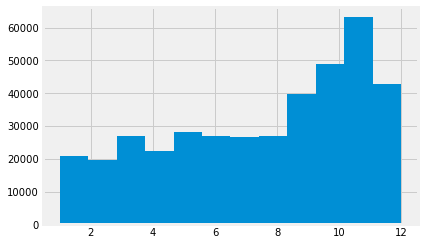

In [48]:
plt.hist(df_cleaned['Month'], bins=12)

(array([64244., 65761., 68064., 79281., 54243.,     0., 61216.]),
 array([0.        , 0.85714286, 1.71428571, 2.57142857, 3.42857143,
        4.28571429, 5.14285714, 6.        ]),
 <a list of 7 Patch objects>)

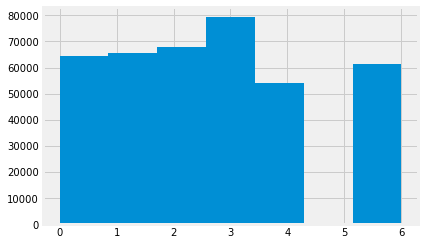

In [49]:
plt.hist(df_cleaned['Weekday'], bins=7)

(array([13490., 11924., 10732., 14634., 16130., 18082., 15430., 15624.,
        12797., 13937., 13211., 10420., 14007., 14020., 11310., 12584.,
        14731., 12687., 10701., 14406., 12980., 12282., 14095., 11922.,
        11838.,  8626., 12206., 13321.,  8033.,  9920.,  6729.]),
 array([ 1.        ,  1.96774194,  2.93548387,  3.90322581,  4.87096774,
         5.83870968,  6.80645161,  7.77419355,  8.74193548,  9.70967742,
        10.67741935, 11.64516129, 12.61290323, 13.58064516, 14.5483871 ,
        15.51612903, 16.48387097, 17.4516129 , 18.41935484, 19.38709677,
        20.35483871, 21.32258065, 22.29032258, 23.25806452, 24.22580645,
        25.19354839, 26.16129032, 27.12903226, 28.09677419, 29.06451613,
        30.03225806, 31.        ]),
 <a list of 31 Patch objects>)

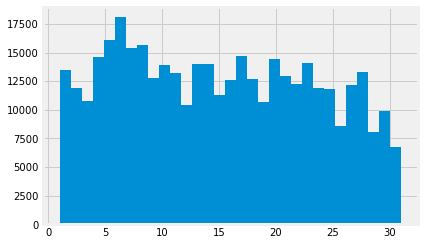

In [50]:
plt.hist(df_cleaned['Day'], bins=31)

(array([3.0000e+00, 3.7900e+02, 0.0000e+00, 8.6890e+03, 0.0000e+00,
        2.1932e+04, 3.7779e+04, 0.0000e+00, 4.8380e+04, 0.0000e+00,
        7.0974e+04, 0.0000e+00, 6.3027e+04, 5.3270e+04, 0.0000e+00,
        4.4795e+04, 0.0000e+00, 2.3722e+04, 1.2949e+04, 0.0000e+00,
        2.8970e+03, 0.0000e+00, 3.2350e+03, 7.7800e+02]),
 array([ 6.        ,  6.58333333,  7.16666667,  7.75      ,  8.33333333,
         8.91666667,  9.5       , 10.08333333, 10.66666667, 11.25      ,
        11.83333333, 12.41666667, 13.        , 13.58333333, 14.16666667,
        14.75      , 15.33333333, 15.91666667, 16.5       , 17.08333333,
        17.66666667, 18.25      , 18.83333333, 19.41666667, 20.        ]),
 <a list of 24 Patch objects>)

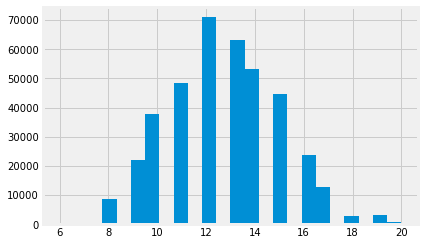

In [51]:
plt.hist(df_cleaned['Hour'], bins=24)

#### 2.2.2 StockCode

Above, it has been seen that some values of the ** StockCode ** field indicate a particular transaction (i.e. D for _Discount_). I check the contents of this field by looking for the set of codes that would contain only letters:

In [52]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [53]:
for code in list_special_codes:
    print("{:<15} -> {:<30}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].unique()[0]))

POST            -> POSTAGE                       
D               -> Discount                      
C2              -> CARRIAGE                      
M               -> Manual                        
BANK CHARGES    -> Bank Charges                  
PADS            -> PADS TO MATCH ALL CUSHIONS    
DOT             -> DOTCOM POSTAGE                


In [54]:
print("{} entries removed".format(len(df_cleaned[df_cleaned['StockCode'].isin(list_special_codes)])))
df_cleaned=df_cleaned[-df_cleaned['StockCode'].isin(list_special_codes)]

1626 entries removed


We see that there are several types of peculiar transactions, connected e.g. to port charges or bank charges. For better product segmentation, I will remove such transactions.


___
#### 2.2.3 Basket Price

I create a new field that indicates the total price of every purchase:

In [55]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Month,Weekday,Day,Hour,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346,United Kingdom,74215,1,1,18,10,0.0
286626,562032,22371,AIRLINE BAG VINTAGE TOKYO 78,8,2011-08-02 08:48:00,4.25,12347,Iceland,0,8,1,2,8,34.0
428996,573511,23308,SET OF 60 VINTAGE LEAF CAKE CASES,24,2011-10-31 12:25:00,0.55,12347,Iceland,0,10,0,31,12,13.2
428997,573511,84991,60 TEATIME FAIRY CAKE CASES,24,2011-10-31 12:25:00,0.55,12347,Iceland,0,10,0,31,12,13.2
428998,573511,84992,72 SWEETHEART FAIRY CAKE CASES,24,2011-10-31 12:25:00,0.55,12347,Iceland,0,10,0,31,12,13.2


Text(0.5, 1.0, 'Revenue per Country')

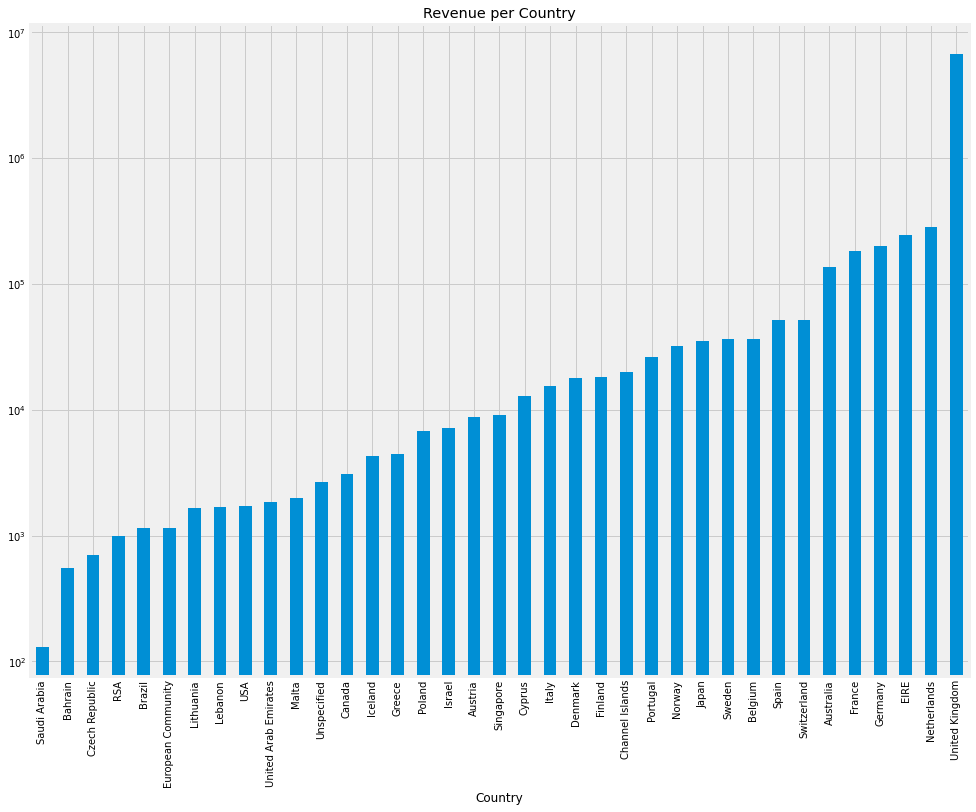

In [56]:
revenue_per_countries = df_cleaned.groupby(["Country"])["TotalPrice"].sum().sort_values()
revenue_per_countries.plot(kind='bar', figsize=(15,12))
plt.yscale('log')
plt.title("Revenue per Country")

Each entry of the dataframe indicates prices for a single kind of product. Hence, orders are split on several lines. I collect all the purchases made during a single order to recover the total order price:

In [57]:
#___________________________________________
# sum of purchases / user and orders
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#_____________________
# order date
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of significant entries:
# basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
0,12346,541431,0.00,2011-01-18 10:01:00.000000000
1,12347,537626,711.79,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,2011-08-02 08:48:00.000000000


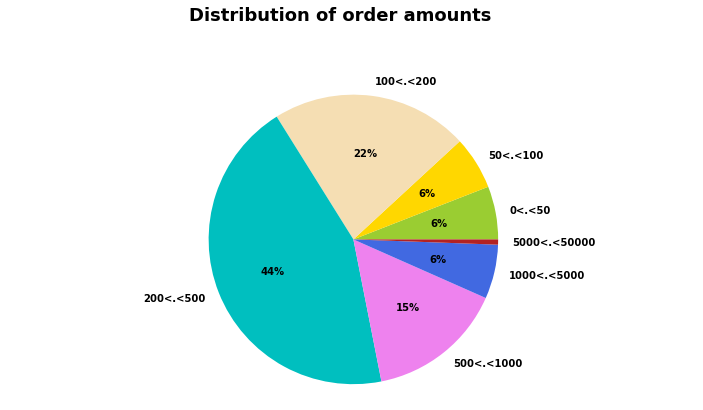

In [58]:
# Show distribution of basket prices in pie chart. 

# Purchase count
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)

# Representation of the number of purchases / amount        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue','firebrick']
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha='center', fontsize = 18);

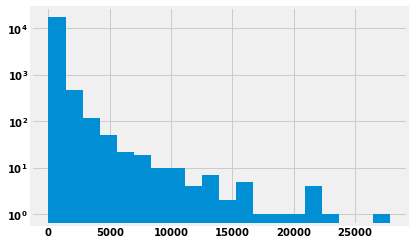

In [59]:
# make histogram distributions of the basket prices 
plt.hist(basket_price['Basket Price'], bins=20)
plt.yscale('log')

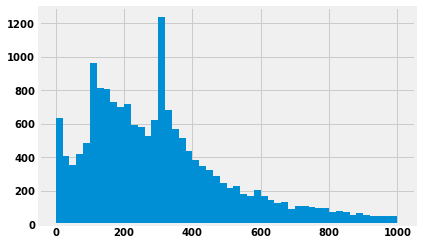

In [60]:
xmax = 1000
# plt.yscale('log')
temp = basket_price[basket_price['Basket Price'] <= xmax]
plt.hist(temp['Basket Price'], bins=50)
plt.show()

It can be seen that the vast majority of orders concern relatively large purchases given that $\sim$65% of purchases give prices in excess of £ 200. There's interesting aspects to this distribution, for example a spike arounf 300, and a rise around 100. 

In [61]:
df_cleaned.Quantity.describe()

count    391183.000000
mean         13.179665
std         181.907403
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

## 3. Insight on product categories

In the dataframe, products are uniquely identified through the **StockCode** field. A short description of the products is given in the **Description** field. In this section, I intend to use the content of this latter variable in order to group the products into different categories.

___
### 3.1 Products Description

As a first step, I extract from the **Description** field the information that will prove useful. To do this, I use the following function:

In [62]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

This function takes as input the dataframe and analyzes the content of the **Description** column by performing the following operations:

- extract the names (proper, common) appearing in the products description
- for each name, I extract the root of the word and aggregate the set of names associated with this particular root
- count the number of times each root appears in the dataframe
- when several words are listed for the same root, I consider that the keyword associated with this root is the shortest name (this systematically selects the singular when there are singular/plural variants)

The first step of the analysis is to retrieve the list of products:

In [63]:
df_produits = pd.DataFrame(df_initial['Description'].unique()).rename(columns = {0:'Description'})

Once this list is created, I use the function I previously defined in order to analyze the description of the various products:

In [64]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1484


The execution of this function returns three values:
- `keywords`: the list of extracted keywords
- `keywords_roots`: a dictionary where the keys are the keywords roots and the values are the lists of words associated with those roots
- `count_keywords`: dictionary listing the number of times every word is used

At this point, I convert the `count_keywords` dictionary into a list, to sort the keywords according to their occurences:

In [65]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

Using it, I create a representation of the most common keywords:

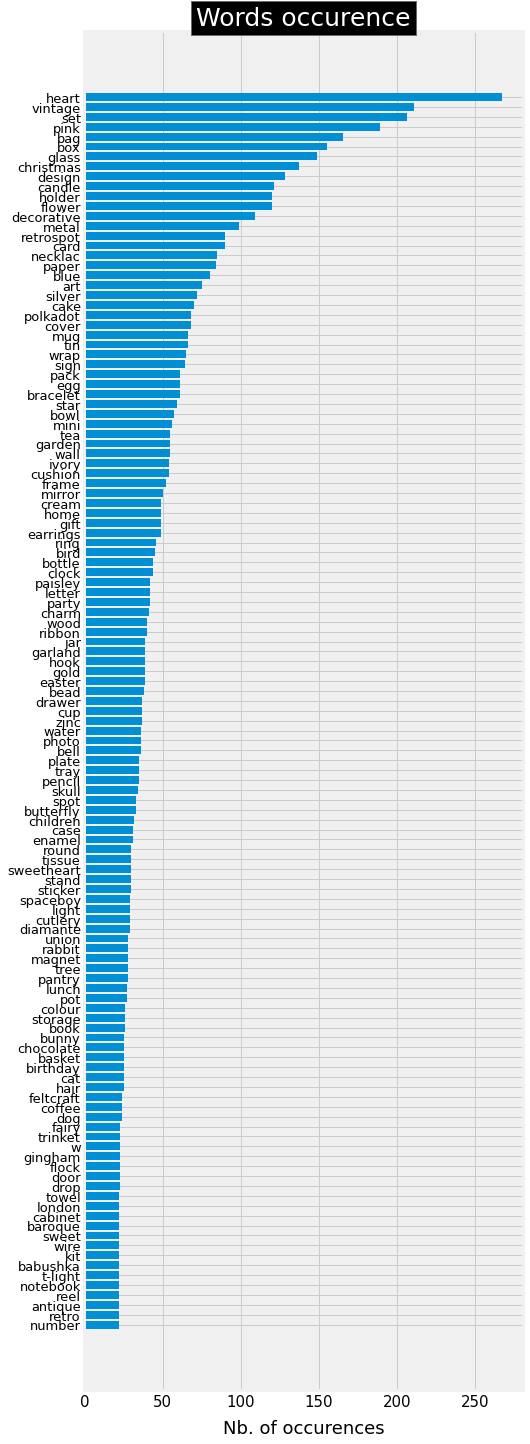

In [66]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

___
### 3.2 Defining product categories 

The list that was obtained contains more than 1400 keywords and the most frequent ones appear in more than 200 products. However, while examinating the content of the list, I note that some names are useless. Others are do not carry information, like colors. Therefore, I discard these words from the analysis that follows and also, I decide to consider only the words that appear more than 13 times.

In [67]:
# use predefined list of stopwords from NLTK package
nltk_stopwords = set(stopwords.words('english'))
# basic function that removes matched stopwords from a dictionary object
def remove_stopwords(corpus: dict):
    temp_dict = {} # create a temporary dictionary
    tokens = keywords_select.keys()
    filtered_tokens = list(filter(lambda token: token not in nltk_stopwords, tokens)) # filter for stopwords
    for i in filtered_tokens: # update the temporary dictionary
        temp_dict.update({i: i})
    print(f'{len(keywords_select.keys())-len(temp_dict.keys())} stopwords removed')
    return temp_dict

In [68]:
keywords_select = remove_stopwords(keywords_select) # also prints how many stopwords were removed

9 stopwords removed


In [69]:
# reflect the change on 'count_keywords' dict, too
count_keywords = {k: v for k, v in count_keywords.items() if k in keywords_select.keys()}

In [70]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange'\
                'box', 'sign', 'vintage', 'glass', 'light', 'candle', 'flower']: continue
    if len(word) < 5 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('preserved words:', len(list_products))

preserved words: 121


____
#### 3.2.1 Data encoding

Now I will use these keywords to create groups of product. Firstly, I define the $X$ matrix as:

   
|   | mot 1  |  ...  | mot j  | ...  | mot N  |
|:-:|---|---|---|---|---|
| product 1  | $a_{1,1}$  |     |   |   | $a_{1,N}$  |
| ...        |            |     | ...  |   |   |
|product i   |    ...     |     | $a_{i,j}$    |   | ...  |
|...         |            |     |  ... |   |   |
| product M  | $a_{M,1}$  |     |   |   | $a_{M,N}$   |

where the $a_ {i, j}$ coefficient  is 1 if the description of the product $i$ contains the word $j$, and 0 otherwise. Here I have a row for each product and a column for each keyword. I fill in the entries with zero or 1, depending on whether that product has that keyword in its description.

In [71]:
liste_produits = df_cleaned['Description'].unique()
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
X

,heart,vintag,christma,design,candl,holder,decor,metal,retrospot,necklac,...,alphabet,toadstool,funki,plant,diner,squar,craft,jewel,wallet,point
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3869,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The $X$ matrix indicates the words contained in the description of the products using the *one-hot-encoding* principle. In practice, I have found that introducing the price range results in more balanced groups in terms of element numbers.
Hence, I add 6 extra columns to this matrix, where I indicate the price range of the products:

In [72]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

def categorize_price(price):
    j=0
    while price > threshold[j+1]:
        j+=1
        if j+1 == len(threshold): break
    return label_col[j]

prod_prices=df_cleaned[['Description','UnitPrice']].groupby('Description').mean()
prod_prices['PriceRange']=prod_prices['UnitPrice'].apply(categorize_price)
for col in label_col:
    prods=prod_prices[prod_prices['PriceRange']==col].index
    X.loc[[list(liste_produits).index(prod) for prod in prods],col]=1
X

,heart,vintag,christma,design,candl,holder,decor,metal,retrospot,necklac,...,craft,jewel,wallet,point,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3866,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3867,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3869,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


and to choose the appropriate ranges, I check the number of products in the different groups:

In [73]:
# Return frequency of products by price range. 

X.iloc[:,-6:].sum()

# print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
# for i in range(len(threshold)):
#     if i == len(threshold)-1:
#         col = '.>{}'.format(threshold[i])
#     else:
#         col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
#     print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

0<.<1      963
1<.<2     1009
2<.<3      673
3<.<5      606
5<.<10     470
.>10       150
dtype: int64

In [74]:
prod_prices.groupby('PriceRange').size()

PriceRange
.>10       150
0<.<1      963
1<.<2     1009
2<.<3      673
3<.<5      606
5<.<10     470
dtype: int64

____
#### 3.2.2 Creating clusters of products

In this section, I will group the products into different classes. In the case of matrices with binary encoding, cosine similarity/distance is a commonly-used measure of distance. Since **kmeans** method of sklearn uses a Euclidean distance, I defined my own functions to perform kmeans clustering using cosine distance. In order to define (approximately) the number of clusters that best represents the data, I use the silhouette score as a measure of the "quality" of the segmentation.

In [75]:
def calculate_cosine_similarity(a,b):
    """Calculates the cosine similarity between two vectors"""
    dot_product=np.dot(a,b)
    len_a=np.sqrt(np.dot(a,a))
    len_b=np.sqrt(np.dot(b,b))
    return dot_product/(len_a*len_b+1e-9)

def get_closest_center(v,centers):
    """Find the center that given vector is closest to based on cosine similarity"""
    distances=[calculate_cosine_similarity(c,v) for c in centers]
    return distances.index(max(distances))

def get_center(c):
    """Calculate the center of a list of vectors by averaging the vectors after normalizing them to unit length"""
    return np.array([[i/np.sqrt(sum(i*i))] for i in c]).mean(axis=0)[0]

class KMeans_cosine(object):
    """KMeans clustering based on cosine distance"""
    def __init__(self,vectors,k,max_iter=30,min_sample=10,init_centers=None):
        self.vectors=vectors
        self.n=len(self.vectors)
        self.max_iter=max_iter
        self.min_sample=min_sample
        if init_centers is None:
            self.k=k
            self.centers=self.vectors[np.random.choice(self.n,self.k)]
        else:
            self.centers=init_centers
            self.k=len(init_centers)
        self.clusters=[[] for c in range(self.k)]
        self.labels=[]
        
    def update_cluster(self):
        """Assign vectors to the centers they are closest to"""
        labels=[]
        for v in self.vectors:
            index=get_closest_center(v,self.centers)
            labels.append(index)
            self.clusters[index].append(v)
        self.labels=labels
    
    def update_center(self):
        """Calculate the center of a list of vectors"""
        if min([len(c) for c in self.clusters])<self.min_sample:
            self.centers=self.vectors[np.random.choice(self.n,self.k)]
            self.clusters=[[] for c in range(self.k)]
            self.labels=[]
            return True
        
        new_centers=[]
        for c in self.clusters:
            center=get_center(c)
            new_centers.append(center)
        
        new_centers=np.array(new_centers)
        if (self.centers==new_centers).all():
            return False
        
        self.centers=new_centers
        self.clusters=[[] for c in range(self.k)]
        return True
        
    def fit(self):
        """Iteratively move centers until they have stabilized or the maximum number of iteration has reached"""
        self.update_cluster()
        count=0
        while self.update_center():
            self.update_cluster()
            count+=1
            if count==self.max_iter: 
                break

The cosine kmeans method I constructed is somewhat unstable. Thus I performed 100 iterations for n_clusters from 3 to 8 to get a more stablized picture. The results are:
- For n_clusters = 3 The average silhouette_score is : 0.25673884714979833
- For n_clusters = 4 The average silhouette_score is : 0.32045152822154677
- For n_clusters = 5 The average silhouette_score is : 0.3406799276763692
- For n_clusters = 6 The average silhouette_score is : 0.38970683534465045
- For n_clusters = 7 The average silhouette_score is : 0.3687191429652772
- For n_clusters = 8 The average silhouette_score is : 0.35286912641983464

I chose 6 for it has the highest average silhouette score across all iterations. After that, I ran a few more iterations to find an near-optimal model with an average silhouette score above 0.45.

In [76]:
# generate the cosine distance matrix
dist_matrix=cdist(X,X,'cosine')

In [77]:
# iter_n=100
# avg_silhouette_scores={}

# for n_clusters in range(3,9):
#     tot_score=0
#     for i in range(iter_n):
#         kmeans = KMeans_cosine(X.values,n_clusters,min_sample=50)
#         kmeans.fit()
#         clusters=kmeans.labels
#         silhouette_avg = silhouette_score(dist_matrix, clusters, metric='precomputed')
#         tot_score+=silhouette_avg
#     avg_score=tot_score/iter_n
#     avg_silhouette_scores[n_clusters]=avg_score
#     print("For n_clusters =", n_clusters, "The average silhouette_score is :", avg_score)

In [78]:
n_clusters=6
silhouette_avg=0
# init_centers=pd.read_csv('init_centers.csv').values

while silhouette_avg<0.4:
    #init_centers is provided to replicate one optimal solution I found through many iterations
#     kmeans = KMeans_cosine(X.values,n_clusters,min_sample=50,init_centers=init_centers)
    kmeans = KMeans_cosine(X.values,n_clusters,min_sample=50)
    kmeans.fit()
    clusters=kmeans.labels
    silhouette_avg = silhouette_score(dist_matrix, clusters, metric='precomputed')
    print("The average silhouette_score is :", silhouette_avg)
clusters=np.array(clusters)

The average silhouette_score is : 0.32904107637795116
The average silhouette_score is : 0.5152731388425383


___
#### 3.2.3  Characterizing the content of clusters

I checked the number of elements in each class and did a sanity check by simply looking at the products in a cluster.

In [79]:
prods=pd.DataFrame([liste_produits,clusters]).T
prods.columns=['prod','cluster']
prods['cluster'].value_counts()

3    1009
4     963
1     673
0     606
5     470
2     150
Name: cluster, dtype: int64

In [80]:
prods[prods['cluster']==4].tail(15)

,prod,cluster
3805,KEEP CALM BIRTHDAY WRAP,4
3811,WRAP KEEP CALM BIRTHDAY,4
3817,WRAP A PRETTY THANK YOU,4
3819,DOILY THANK YOU CARD,4
3820,A PRETTY THANK YOU CARD,4
3831,PAISLEY PARK CARD,4
3841,CAT WITH SUNGLASSES BLANK CARD,4
3845,HAND PAINTED HANGING EASTER EGG,4
3862,"LETTER ""F"" BLING KEY RING",4
3863,"LETTER ""O"" BLING KEY RING",4


It's worth noting that because the majority of the matrix is sparse and a product must be categorized to one of the price baskets, the clustering result is dominated by the price range. In one extreme iteration, the six clusters are exactly separated by the price range.

In [81]:
cluster_price=X[['0<.<1', '1<.<2', '2<.<3', '3<.<5','5<.<10', '.>10']].copy()
cluster_price['cluster']=clusters
cluster_price.groupby('cluster').mean()

,0<.<1,1<.<2,2<.<3,3<.<5,5<.<10,.>10
cluster,,,,,,
0,0,0,0,1,0,0
1,0,0,1,0,0,0
2,0,0,0,0,0,1
3,0,1,0,0,0,0
4,1,0,0,0,0,0
5,0,0,0,0,1,0



** a / _Silhouette intra-cluster score_ **

In order to have an insight on the quality of the classification, we can represent the silhouette scores of each element of the different clusters. This is the purpose of the next figure which is taken from the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html):

In [82]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
#     plt.rcParams["patch.force_edgecolor"] = True
    plt.style.use('fivethirtyeight')
    mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
    #____________________________
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    for i in range(n_clusters):
        #___________________________________________________________________________________
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,
                           facecolor=color, edgecolor=color, alpha=0.8)
        #____________________________________________________________________
        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        #______________________________________
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  

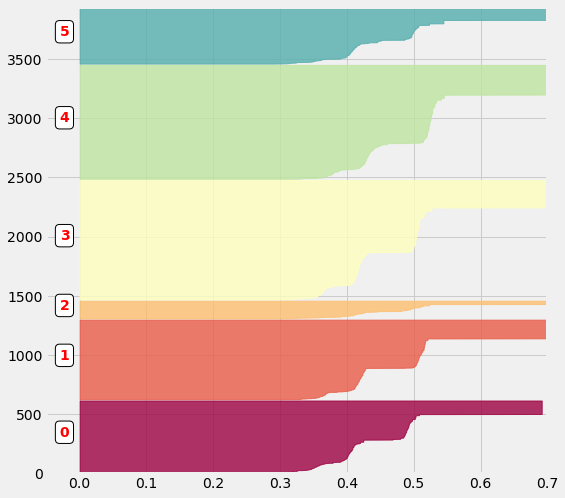

In [83]:
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(dist_matrix, clusters,metric="precomputed")
#__________________
# and do the graph
graph_component_silhouette(n_clusters, [-0.05, 0.7], len(X), sample_silhouette_values, clusters)

** b/ _Word Cloud_**

Now we can have a look at the type of objects that each cluster represents. In order to obtain a global view of their contents, I determine which keywords are the most frequent in each of them

In [84]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag',]: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

and I output the result as wordclouds:

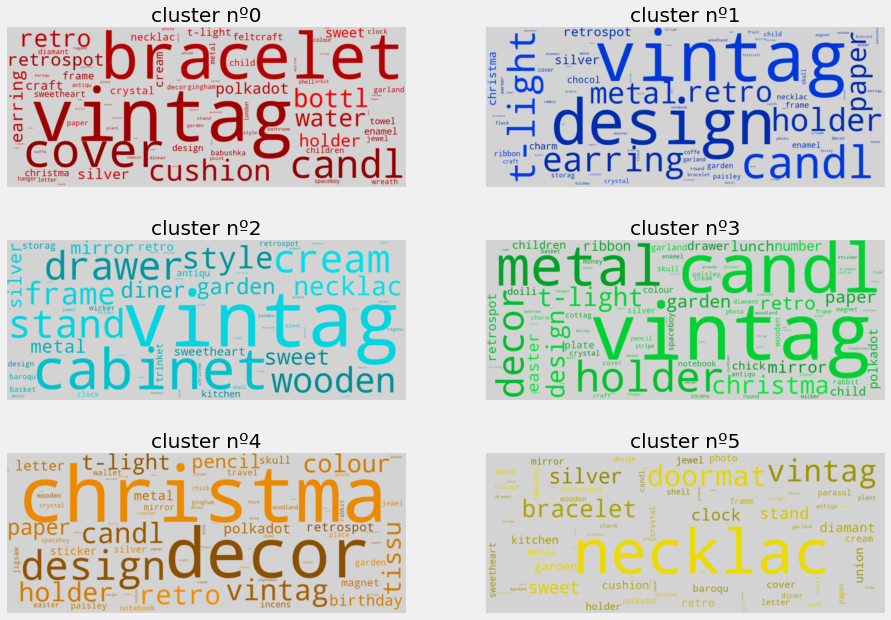

In [85]:
#________________________________________________________________________
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)            

From this representation, we can see that for example, cluster #0 seems to have many jewleries in it (keyword: bracelet, necklac ...). Cluster #2 is related to holidays (keywords: christmas, decoration, ...).
cluster #4 is mostly cushion covers. Cluster #5 contains objects that could be associated with household products and furnitures (keywords: cabinet, cutlery, drawer, stand ...).  We may consider combining cluster 4 and 5 because they both belong to home decoration broad category. 

Even with fine tuning and many iterations, we can still find many words appearing in various clusters. This imperfect result is expected because at the end of the day machines can only do what we tell them to do, in our case here, that is to find similar words based on how they are spelled, not what they mean. The machine has no way to know "cushion" is closer to "cabinet" than it is to "bracelet". In real world, it's very unlikely a business will do unsupervised product segmentation like this. 

** c / _Principal Component Analysis_ **

In order to ensure that these clusters are reasonably distinct, I look at their composition in a relevant low dimensional space. Given the large number of variables of the initial matrix, I first perform a PCA:

In [86]:
# Perform PCA to subsequently check distinctness between clusters.
matrix=X.values
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

and then check for the amount of variance explained by each component:

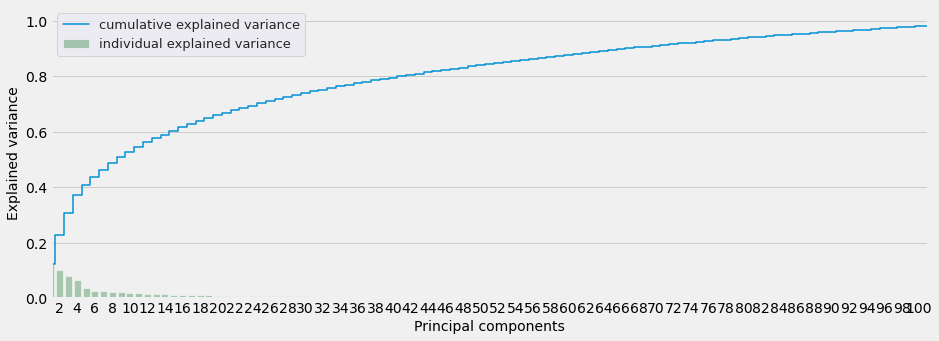

In [87]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 100)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='upper left', fontsize = 13);

We see that the number of components required to explain the data is extremely important: we need more than 100 components to explain 90% of the variance of the data. So we find that the space contains lots of variance in many non correlated directions, and PCA doesn't really help that much. In practice, I decide to keep only a limited number of components since this decomposition is only performed to visualize the data:

In [88]:
pca = PCA(n_components=50)
matrix_9D = pca.fit_transform(matrix)
mat = pd.DataFrame(matrix_9D)
mat['cluster'] = pd.Series(clusters)

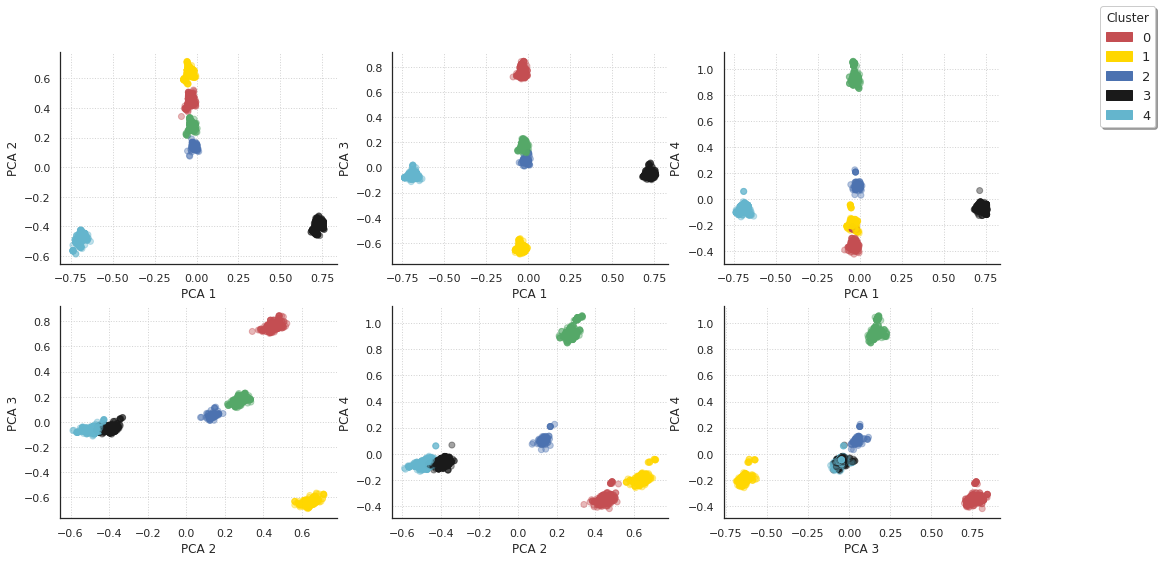

In [89]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'gold', 2:'b', 3:'k', 4:'c', 5:'g'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (15,8))
increment = 0
for ix in range(4):
    for iy in range(ix+1, 4):    
        increment += 1
        ax = fig.add_subplot(2,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.4) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 9: break
    if increment == 9: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(5):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.97), 
           title='Cluster',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.show()

___
## 4. Customer categories

### 4.1 Formatting data

In the previous section, the different products were grouped in five clusters. In order to prepare the rest of the analysis, a first step consists in introducing this information into the dataframe. To do this, I create the categorical variable **categ_product** where I indicate the cluster of each product :

In [90]:
# Append product category per above clustering to dataframe.

corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Month,Weekday,Day,Hour,TotalPrice,categ_product
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,12,2,1,8,15.30,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,12,2,1,8,20.34,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,12,2,1,8,22.00,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,12,2,1,8,20.34,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,12,2,1,8,20.34,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,0,12,4,9,12,10.20,4
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,0,12,4,9,12,12.60,1
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,0,12,4,9,12,16.60,0
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,0,12,4,9,12,16.60,0


___
#### 4.1.1 Grouping products

In a second step, I decide to create the **categ_N** variables (with $ N \in [0: 5]$) that contains the amount spent in each product category:

In [91]:
for i in range(6):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 
            'categ_1', 'categ_2', 'categ_3','categ_4','categ_5']][:5]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1,0.00,15.3,0.0,0.0,0.0,0.0
1,536365,WHITE METAL LANTERN,0,20.34,0.0,0.0,0.0,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,0,22.00,0.0,0.0,0.0,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,0,20.34,0.0,0.0,0.0,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,0,20.34,0.0,0.0,0.0,0.0,0.0


By sales revenue, category 0, 1 and 3 are the top three categories.

In [92]:
df_cleaned[['categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4','categ_5']].sum()

categ_0    1488198.63
categ_1    2019696.34
categ_2     481805.07
categ_3    1976715.98
categ_4     990268.91
categ_5    1295432.12
dtype: float64

Up to now, the information related to a single order was split over several lines of the dataframe (one line per product). I decide to collect the information related to a particular order and put in in a single entry. I therefore create a new dataframe that contains, for each order, the amount of the basket, as well as the way it is distributed over the 5 categories of products:

In [93]:
# Create dataframe which combines purchase information for each distinct Invoice Number. 
#___________________________________________
# sum of purchases / user & order
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# percentage of the price of the order / product category
for i in range(n_clusters):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
#_____________________
# order date
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection of significant entries:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,InvoiceDate
1,12347,537626,711.79,293.35,83.40,0.00,187.2,23.40,124.44,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,169.20,53.10,38.25,130.5,84.34,0.00,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,115.00,71.10,38.25,330.9,81.00,0.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,168.76,78.06,0.00,74.4,41.40,19.90,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,158.16,119.70,38.25,109.7,61.30,97.80,2011-08-02 08:48:00.000000000


#### 4.1.2 Separation of data over time

The dataframe `basket_price` contains information for a period of 12 months. Later, one of the objectives will be to develop a model capable of characterizing and anticipating the habits of the customers visiting the site and this, from their first visit. In order to be able to test the model in a realistic way, I split the data set by retaining the first 10 months to develop the model and the following two months to test it:

In [94]:
print(basket_price['InvoiceDate'].min(), '->',  basket_price['InvoiceDate'].max())

2010-12-01 08:26:00 -> 2011-12-09 12:50:00


In [95]:
temp1 = datetime(2011,10,1)
temp = np.datetime64(datetime(2011,10,1))
print(temp)

2011-10-01T00:00:00.000000


In [96]:
type(temp)

numpy.datetime64

In [97]:
print(basket_price['InvoiceDate'])

1       2010-12-07 14:57:00.000001024
2       2011-01-26 14:29:59.999999744
3       2011-04-07 10:42:59.999999232
4       2011-06-09 13:01:00.000000256
5       2011-08-02 08:48:00.000000000
                     ...             
18400   2011-11-30 12:58:59.999998720
18401   2011-12-06 12:02:00.000001792
18402   2011-05-22 10:38:59.999998976
18403   2011-10-12 10:22:59.999998720
18404   2011-10-28 09:29:00.000000000
Name: InvoiceDate, Length: 18275, dtype: datetime64[ns]


In [98]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < np.datetime64(datetime(2011,10,1))]
set_test         = basket_price[basket_price['InvoiceDate'] >= np.datetime64(datetime(2011,10,1))]

In [99]:
basket_price.head()

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,InvoiceDate
1,12347,537626,711.79,293.35,83.40,0.00,187.2,23.40,124.44,2010-12-07 14:57:00.000001024
2,12347,542237,475.39,169.20,53.10,38.25,130.5,84.34,0.00,2011-01-26 14:29:59.999999744
3,12347,549222,636.25,115.00,71.10,38.25,330.9,81.00,0.00,2011-04-07 10:42:59.999999232
4,12347,556201,382.52,168.76,78.06,0.00,74.4,41.40,19.90,2011-06-09 13:01:00.000000256
5,12347,562032,584.91,158.16,119.70,38.25,109.7,61.30,97.80,2011-08-02 08:48:00.000000000


____
#### 4.1.3 Consumer Order Combinations

In a second step, I group together the different entries that correspond to the same user. I thus determine the number of purchases made by the user, as well as the minimum, maximum, average amounts and the total amount spent during all the visits. For each customer, I also added the total dollar value of all his or her cancelled items as a percentage of total purchase amount, as well as the number of distinct products bought.

In [100]:

# Group all relevent information together for each customer.
#________________________________________________________________
# number of visits and stats on the cart amount / users
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(n_clusters):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

df_cleaned['CanceledValue']=df_cleaned['QuantityCanceled']*df_cleaned['UnitPrice']
transactions_per_user=transactions_per_user.merge(
    df_cleaned[['CustomerID','CanceledValue']].groupby('CustomerID').sum(),
    left_index=True,right_index=True)
transactions_per_user['canceled%']=transactions_per_user['CanceledValue']/transactions_per_user['sum']*100
transactions_per_user['canceled%']=transactions_per_user['canceled%'].apply(lambda x: 100 if x>100 else x)

transactions_per_user=transactions_per_user.merge(
    df_cleaned[['Description','CustomerID']].groupby('CustomerID').nunique().\
    rename(columns={'Description':'unique_prod'}),
    left_index=True,right_index=True)

transactions_per_user.drop(columns='CanceledValue',inplace=True)
transactions_per_user.index.name = None
transactions_per_user.reset_index(drop = False, inplace = True)

transactions_per_user.drop(columns='CustomerID', inplace=True)
transactions_per_user.rename(columns={'index':'CustomerID'}, inplace=True)
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,canceled%,unique_prod
0,12347,7,224.82,1294.32,615.714286,4310.00,29.540371,20.805104,4.437355,26.375870,11.237123,7.604176,0.000000,103
1,12348,4,187.44,652.80,359.310000,1437.24,0.000000,0.000000,0.000000,52.461663,47.538337,0.000000,0.000000,21
2,12349,1,1457.55,1457.55,1457.550000,1457.55,12.918939,14.765874,10.325546,31.961854,5.442009,24.585778,0.000000,72
3,12350,1,294.40,294.40,294.400000,294.40,0.000000,31.691576,0.000000,55.027174,13.281250,0.000000,0.000000,16
4,12352,6,104.35,296.50,210.901667,1265.41,27.528627,7.675773,5.037893,29.609376,2.449799,27.698532,9.509171,57


Finally, I define two additional variables that give the number of days elapsed since the first purchase (** FirstPurchase **) and the number of days since the last purchase (** LastPurchase **):

In [101]:
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase      = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test  = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transactions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transactions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

transactions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,canceled%,unique_prod,LastPurchase,FirstPurchase
0,12347,7,224.82,1294.32,615.714286,4310.00,29.540371,20.805104,4.437355,26.375870,11.237123,7.604176,0.000000,103,2,367
1,12348,4,187.44,652.80,359.310000,1437.24,0.000000,0.000000,0.000000,52.461663,47.538337,0.000000,0.000000,21,75,358
2,12349,1,1457.55,1457.55,1457.550000,1457.55,12.918939,14.765874,10.325546,31.961854,5.442009,24.585778,0.000000,72,18,18
3,12350,1,294.40,294.40,294.400000,294.40,0.000000,31.691576,0.000000,55.027174,13.281250,0.000000,0.000000,16,310,310
4,12352,6,104.35,296.50,210.901667,1265.41,27.528627,7.675773,5.037893,29.609376,2.449799,27.698532,9.509171,57,36,296


95% customers returned less than 10% of their purchase in value, purchased less than 205 different products and visited the shop less than 13 times.

"Canceled %" 95 quantile: 8.381914702200358


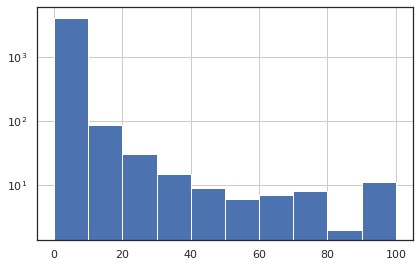

In [102]:
print('"Canceled %" 95 quantile:',transactions_per_user['canceled%'].quantile(0.95))
transactions_per_user['canceled%'].hist()
plt.yscale('log')

"Unique Products" 95 quantile: 205.0


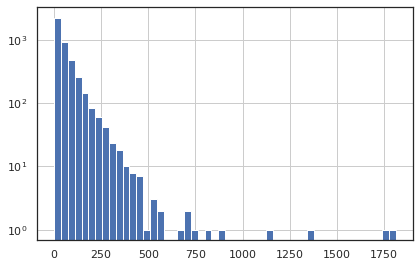

In [103]:
print('"Unique Products" 95 quantile:',transactions_per_user['unique_prod'].quantile(0.95))
transactions_per_user['unique_prod'].hist(bins=50)
plt.yscale('log')

"Count" 95 quantile: 13.0


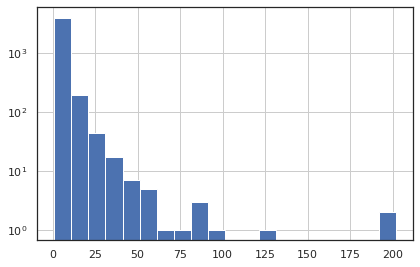

In [104]:
print('"Count" 95 quantile:',transactions_per_user['count'].quantile(0.95))
transactions_per_user['count'].hist(bins=20)
plt.yscale('log')

"Mean" 95 quantile: 895.2274999999972


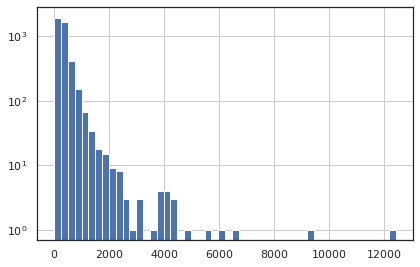

In [105]:
print('"Mean" 95 quantile:',transactions_per_user['mean'].quantile(0.95))
transactions_per_user['mean'].hist(bins=50)
plt.yscale('log')

In [106]:
transactions_per_user.describe()

,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,canceled%,unique_prod,LastPurchase,FirstPurchase
count,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000
mean,4.226411,243.208788,571.082248,370.048220,1908.445201,17.163062,21.892835,6.059969,25.656413,14.261521,14.966199,1.943780,61.872803,92.347595,222.925994
std,7.561535,347.931760,1116.117898,454.242363,8286.392597,14.682189,16.936049,11.903736,17.053961,15.076200,15.682869,8.134385,86.229822,100.262411,117.773021
min,1.000000,0.380000,2.900000,2.900000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,1.000000,95.202500,215.657500,173.893750,299.975000,7.419221,11.423458,0.000000,14.751643,4.426122,3.845007,0.000000,16.000000,17.000000,113.000000
50%,2.000000,165.575000,357.990000,284.557500,652.405000,15.039060,19.526481,1.450141,24.110798,10.649386,11.590664,0.000000,35.000000,50.000000,248.000000
75%,5.000000,305.010000,599.542500,421.780000,1610.457500,23.516516,29.053106,7.336477,33.772294,18.968645,20.979738,0.749739,78.000000,143.000000,326.000000
max,202.000000,9338.380000,27872.800000,12425.450000,278742.020000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,1814.000000,373.000000,373.000000


In [107]:
transactions_per_user.quantile(0.97)

count              17.310000
min               821.751000
max              1928.952200
mean             1111.704850
sum              7845.228800
categ_0            51.327251
categ_1            62.930649
categ_2            34.712591
categ_3            63.497687
categ_4            51.404106
categ_5            51.584657
canceled%          13.833828
unique_prod       247.310000
LastPurchase      336.000000
FirstPurchase     372.000000
Name: 0.97, dtype: float64

I capped the long tails at around 97% quantile.

In [108]:
transactions_per_user['count']=transactions_per_user['count'].clip(upper=20)
transactions_per_user['min']=transactions_per_user['min'].clip(upper=1000)
transactions_per_user['max']=transactions_per_user['max'].clip(upper=2000)
transactions_per_user['mean']=transactions_per_user['mean'].clip(upper=1500)
transactions_per_user['canceled%']=transactions_per_user['canceled%'].clip(upper=15)
transactions_per_user['unique_prod']=transactions_per_user['unique_prod'].clip(upper=300)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


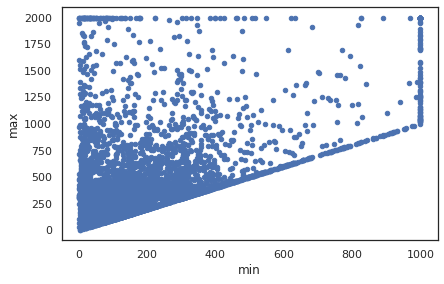

In [109]:
transactions_per_user.plot.scatter('min','max')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


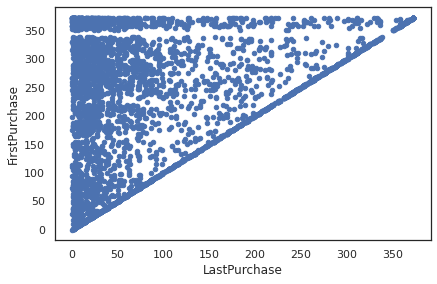

In [110]:
transactions_per_user.plot.scatter('LastPurchase','FirstPurchase')

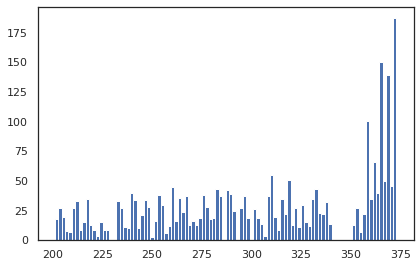

In [111]:
temp = transactions_per_user[transactions_per_user['FirstPurchase'] > 200]
fig = plt.hist(temp['FirstPurchase'], bins = 100)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


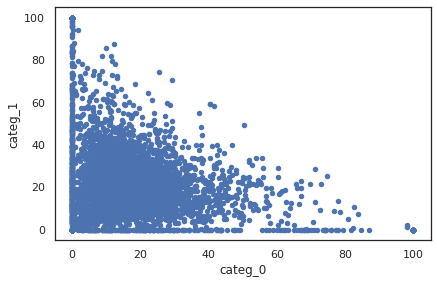

In [112]:
transactions_per_user.plot.scatter('categ_0','categ_1')

A customer category of particular interest is that of customers who make only one purchase. I find that this type of customer represents 1/3 of the customers listed. When doing customer segmentation, I'll put all these "one-time-buyers" into their own segment.

In [113]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("number of customers with a single purchase: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))
print(f"number of customers with more than one purchases: {n2-n1}")

number of customers with a single purchase: 1502/4324  (34.74%)
number of customers with more than one purchases: 2822


Compared to multi-time buyers, one-time buyers have a lower canceled value percentage and slighly smaller average order size. In terms of product mix, there doesn't seem to be a big diffference.

In [114]:
selected_customers = transactions_per_user[transactions_per_user['count'] > 1].copy(deep = True)
single_buyers=transactions_per_user[transactions_per_user['count'] == 1]
customer_comparison=pd.DataFrame([single_buyers.mean().values,selected_customers.mean().values],
                                    columns=single_buyers.columns,
                                    index=['one_time_buyers','multi_time_buyers']).drop(columns='CustomerID')
customer_comparison

,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,canceled%,unique_prod,LastPurchase,FirstPurchase
one_time_buyers,1.000000,316.093509,339.546651,331.420186,358.929148,17.043799,20.419834,6.955735,25.565192,14.865226,15.150213,0.797867,21.820240,156.609854,156.609854
multi_time_buyers,5.322112,176.283437,573.671754,357.075940,2733.169904,17.226540,22.676836,5.583201,25.704965,13.940201,14.868258,1.462370,78.658753,58.144224,258.222537


___
### 4.2 Creation of customers categories

#### 4.2.1 Data encoding

The dataframe `transactions_per_user` contains a summary of all the commands that were made. Each entry in this dataframe corresponds to a particular client. I use this information to characterize the different types of customers and only keep a subset of variables:

In [115]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4', 'categ_5',
             'canceled%','unique_prod']
#_____________________________________________________________
matrix = selected_customers[list_cols].to_numpy()

In practice, the different variables I selected have quite different ranges of variation and before continuing the analysis, I  create a matrix where these data are standardized:

In [116]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  5.32211198 176.28343728 573.67175408 357.07593982  17.22653983
  22.67683561   5.58320079  25.70496545  13.94020067  14.86825766
   1.46237001  78.65875266]


In the following, I will create clusters of customers. In practice, before creating these clusters, it is interesting to define a base of smaller dimension allowing to describe the `scaled_matrix` matrix. In this case, I will use this base in order to create a representation of the different clusters and thus verify the quality of the separation of the different groups. I therefore perform a PCA beforehand:

In [117]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

and I represent the amount of variance explained by each of the components:

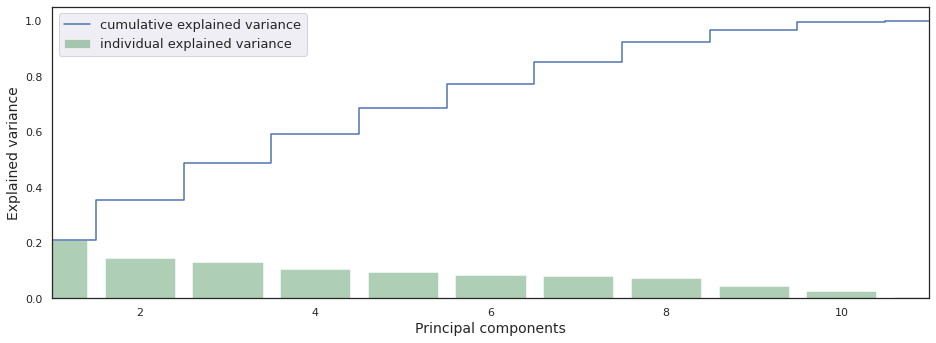

In [118]:
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
         label='cumulative explained variance')
sns.barplot(np.arange(1,matrix.shape[1]+1), pca.explained_variance_ratio_, alpha=0.5, color = 'g',
            label='individual explained variance')
plt.xlim(0, 10)

ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel('Explained variance', fontsize = 14)
plt.xlabel('Principal components', fontsize = 14)
plt.legend(loc='best', fontsize = 13);

___
#### 4.2.2 Creation of customer categories


At this point, I define clusters of clients from the standardized matrix that was defined earlier and using the `k-means` algorithm from` scikit-learn`. I choose the number of clusters based on the silhouette score and I find that a pretty good score is obtained with 11 clusters:

In [119]:
for n in range(6,12):
    kmeans = KMeans(init='k-means++', n_clusters = n, n_init=100)
    kmeans.fit(scaled_matrix)
    clusters_clients = kmeans.predict(scaled_matrix)
    silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
    print('number of clusters is ',n, '  silhouette score: {:<.3f}'.format(silhouette_avg))
    print(pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T,'\n')

number of clusters is  6   silhouette score: 0.137
                  5    1    2    4    3    0
nb. de clients  801  766  430  406  252  167 

number of clusters is  7   silhouette score: 0.132
                  3    0    6    5    2    1    4
nb. de clients  716  659  380  358  301  251  157 

number of clusters is  8   silhouette score: 0.144
                  5    3    1    0    6    7    4    2
nb. de clients  704  636  385  370  245  209  156  117 

number of clusters is  9   silhouette score: 0.149
                  0    8    7    3    6    1    2    5    4
nb. de clients  667  588  377  344  236  181  153  152  124 

number of clusters is  10   silhouette score: 0.148
                  4    1    2    9    5    6    0    7    8    3
nb. de clients  870  316  315  248  223  215  183  178  149  125 

number of clusters is  11   silhouette score: 0.153
                 8    4    9    2    0    3    1    5    7    10   6 
nb. de clients  867  339  307  215  178  177  173  169  140  1

In [120]:
n_clusters_cust= 8
kmeans = KMeans(init='k-means++', n_clusters = n_clusters_cust, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('silhouette score: {:<.3f}'.format(silhouette_avg))

silhouette score: 0.144


At first, I look at the number of customers in each cluster:

In [121]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

,4,3,2,1,7,0,6,5
nb. de clients,696,679,382,369,243,184,154,115





** a / _Report via the PCA_ **

There is a certain disparity in the sizes of different groups that have been created. Hence I will now try to understand the content of these clusters in order to validate (or not) this particular separation. At first, I use the result of the PCA:

In [122]:
pca = PCA(n_components=6)
matrix_3D = pca.fit_transform(scaled_matrix)
mat = pd.DataFrame(matrix_3D)
mat['cluster'] = pd.Series(clusters_clients)

in order to create a representation of the various clusters:

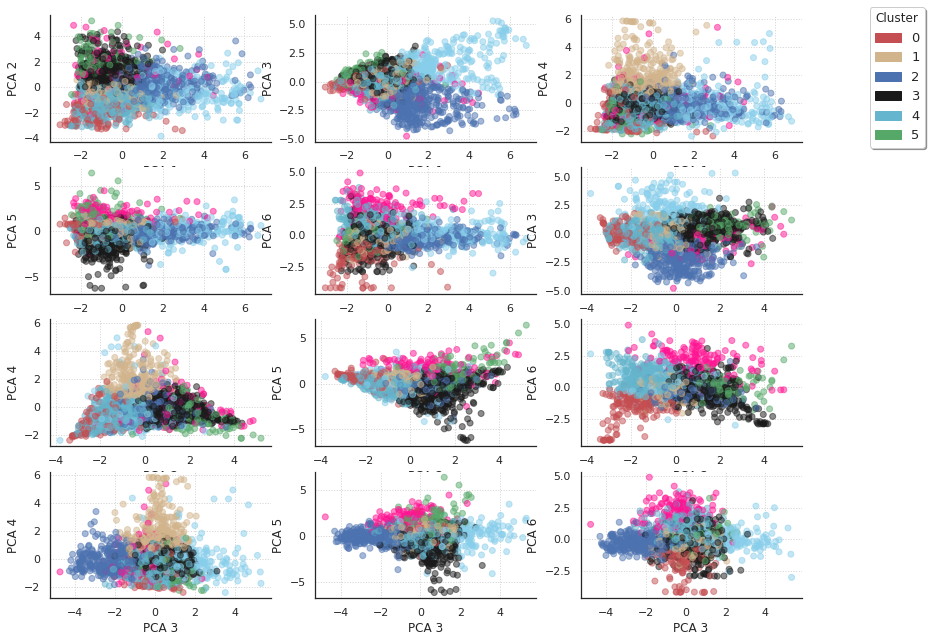

In [123]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c', 5:'g', 6:'deeppink', 7:'skyblue', 8:'darkcyan', 9:'orange',
                   10:'yellow', 11:'tomato', 12:'seagreen'}
label_color = [LABEL_COLOR_MAP[l] for l in mat['cluster']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(6):
    for iy in range(ix+1, 6):   
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(mat[ix], mat[iy], c= label_color, alpha=0.5) 
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        
        if increment == 12: break
    if increment == 12: break
        
#_______________________________________________
# I set the legend: abreviation -> airline name
comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9), 
           title='Cluster', 
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()



From this representation, it can be seen, for example, that the first principal component allow to separate the tiniest clusters from the rest. More generally, we see that there is always a representation in which two clusters will appear to be distinct.

** b/ _Score de silhouette intra-cluster_ **

As with product categories, another way to look at the quality of the separation is to look at silouhette scores within different clusters:

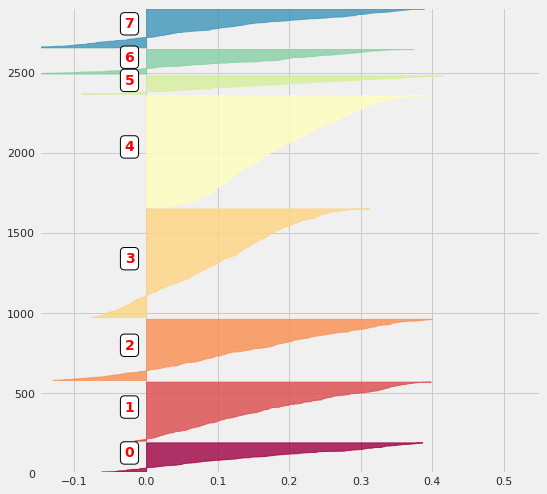

In [124]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#____________________________________
# define individual silouhette scores
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)
#__________________
# and do the graph
graph_component_silhouette(n_clusters_cust, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

** c/ _Customers morphotype_**

At this stage, I have verified that the different clusters are reasonably disjoint (at least, in a global way). It remains to understand the behavior of the customers in each cluster. To do so, I start by adding to the `selected_customers` dataframe a variable that defines the cluster to which each client belongs:

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2822 samples in 0.018s...
[t-SNE] Computed neighbors for 2822 samples in 0.331s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2822
[t-SNE] Computed conditional probabilities for sample 2000 / 2822
[t-SNE] Computed conditional probabilities for sample 2822 / 2822
[t-SNE] Mean sigma: 0.863889
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.884949
[t-SNE] KL divergence after 500 iterations: 1.564560


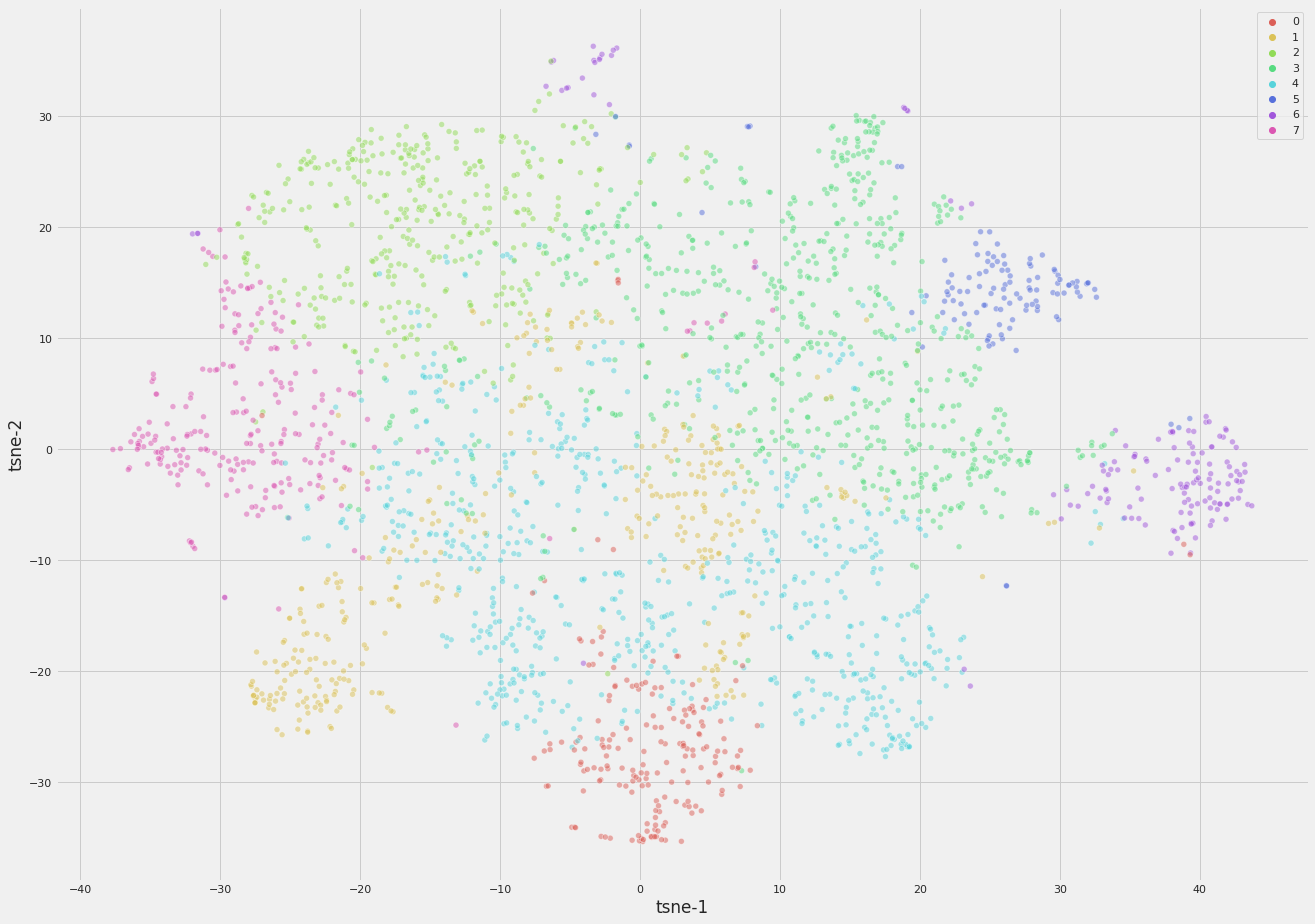

In [125]:
# We draw the TSNE plot to visualize the eight customer clusters.
plt.figure(figsize=(20,15))
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_ft = tsne.fit_transform(scaled_matrix)
km_data = pd.DataFrame(kmeans.predict(scaled_matrix), columns=['y'])
km_data['tsne-1'] = tsne_ft[:, 0]
km_data['tsne-2'] = tsne_ft[:, 1]
sns.scatterplot(x="tsne-1", y="tsne-2",hue=km_data["y"].tolist(), palette=sns.color_palette("hls", 8),
    data=km_data, legend="full", alpha=0.5)

In [126]:
selected_customers.loc[:, 'cluster'] = clusters_clients

Then, I average the contents of this dataframe by first selecting the different groups of clients. This gives access to, for example, the average baskets price, the number of visits or the total sums spent by the clients of the different clusters. I also determine the number of clients in each group (variable ** size **):

In [127]:
merged_df = pd.DataFrame()
for i in range(n_clusters_cust):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
#_____________________________________________________
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('number of customers:', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

number of customers: 2822


Finally, I re-organize the content of the dataframe by ordering the different clusters: first, in relation to the amount wpsent in each product category and then, according to canceled%, number of unique products, and the total amount spent:

In [128]:
liste_index = []
focused_cols=['categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4', 'categ_5', 
              'canceled%', 'unique_prod','sum']
for col in focused_cols:
    idx=merged_df[col].idxmax()
    if idx not in liste_index:
        liste_index.append(idx)
liste_index_reordered = liste_index.copy()
liste_index_reordered += [ s for s in merged_df.index if s not in liste_index]
merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
merged_df['cluster']=merged_df['cluster'].astype(int)
merged_df

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,canceled%,unique_prod,LastPurchase,FirstPurchase,size
0,3,4.063328,152.068660,395.557806,263.517575,1076.257482,26.109659,16.398732,5.631629,17.317088,8.657420,25.885472,0.725964,57.727541,64.097202,251.328424,679
1,1,4.081301,153.802520,420.185610,277.713888,1188.201897,11.692550,47.428641,2.584547,19.109917,10.306449,8.877896,0.570051,44.886179,65.463415,256.037940,369
2,5,4.252174,150.738000,383.607391,253.456333,1176.944957,11.208684,13.478191,36.857999,14.021422,6.389327,18.044377,1.419031,35.504348,88.808696,257.747826,115
3,4,3.989943,173.298420,438.646882,295.381239,1176.143994,14.209550,17.999913,2.890385,41.067988,14.959084,8.873080,0.721302,62.942529,58.132184,235.705460,696
4,0,3.744565,142.524457,383.286033,248.792263,957.975217,8.165767,13.868953,1.438486,22.533605,48.672089,5.321101,0.655090,47.755435,72.679348,244.271739,184
5,6,4.850649,121.591104,513.383636,299.501765,2012.873701,16.812905,22.346401,7.137396,24.436612,11.568547,17.698138,12.668869,56.844156,74.000000,260.123377,154
6,2,13.086387,92.726518,941.988403,446.351171,10086.573953,17.510142,24.268072,5.105952,24.915990,13.023245,15.176599,1.236008,197.890052,17.130890,323.879581,382
7,7,4.333333,490.298272,1384.490082,942.894762,5146.148189,18.974806,24.759483,5.816982,25.129374,11.520095,13.799260,0.883199,103.658436,59.337449,251.666667,243


** d / _Customers morphology_ **

Finally, I created a representation of the different morphotypes. To do this, I define a class to create "Radar Charts" (which has been adapted from this [kernel](https://www.kaggle.com/yassineghouzam/don-t-know-why-employees-leave -read-this)):

In [129]:
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]

class RadarChart():
    def __init__(self, fig, location, sizes, variables, ranges, n_ordinate_levels = 6):

        angles = np.arange(0, 360, 360./len(variables))

        ix, iy = location[:] ; size_x, size_y = sizes[:]
        
        axes = [fig.add_axes([ix, iy, size_x, size_y], polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]

        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            if angle > -1 and angle < 181:
                txt.set_rotation(angle - 90)
            else:
                txt.set_rotation(angle - 270)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.0f}".format(x) for x in grid[1:-1]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
        
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
                
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)


This allows to have a global view of the content of each cluster:

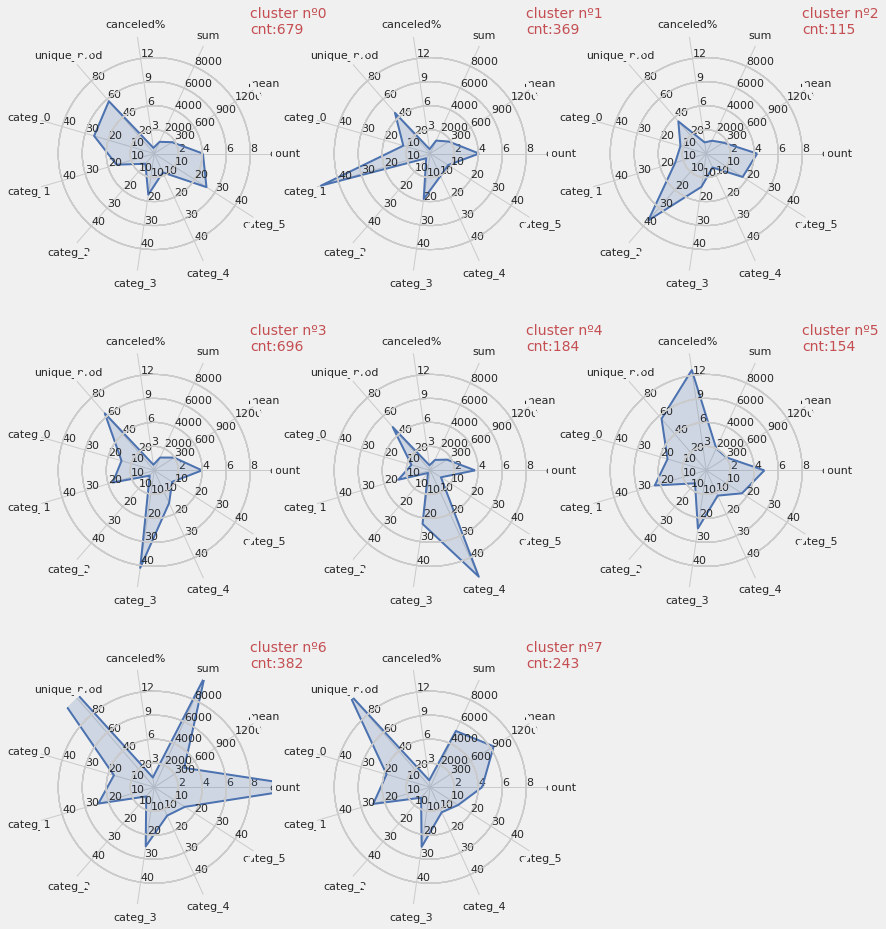

In [130]:
fig = plt.figure(figsize=(10,8))

attributes = ['count', 'mean', 'sum', 'canceled%','unique_prod',
              'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4','categ_5']
ranges = [[0.01, 10], [0.01, 1500], [0.01, 10000], [0.01, 15], [0.01,100],
          [0.01, 50], [0.01, 50], [0.01, 50], [0.01, 50], [0.01, 50], [0.01, 50]]
index  = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

n_groups = n_clusters_cust ; i_cols = 3
i_rows = n_groups//i_cols
size_x, size_y = (1/i_cols), (1/i_rows)

for ind in range(n_clusters_cust):
    ix = ind%3 ; iy = i_rows - ind//3
    pos_x = ix*(size_x + 0.05) ; pos_y = iy*(size_y + 0.05)            
    location = [pos_x, pos_y]  ; sizes = [size_x, size_y] 
    #______________________________________________________
    data = np.array(merged_df.loc[index[ind], attributes])    
    radar = RadarChart(fig, location, sizes, attributes, ranges)
    radar.plot(data, color = 'b', linewidth=2.0)
    radar.fill(data, alpha = 0.2, color = 'b')
    radar.title(title = 'cluster nº{}\ncnt:{}'.format(index[ind],merged_df.loc[index[ind], "size"]), color = 'r')
    ind += 1 

It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (**mean**), the total sum spent by the clients (**sum**) or the total canceled value as a percent of total spent (**canceled%**).

# Customer Value Measures

In [131]:
cvm=transactions_per_user[['sum','count','max','unique_prod','canceled%']].copy()
cvm.rename(columns={'count':'num_visits','max':'max_order'},inplace=True)
print("Number of customers:",len(cvm))
cvm.describe()

Number of customers: 4324


,sum,num_visits,max_order,unique_prod,canceled%
count,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000
mean,1908.445201,3.820768,492.345227,58.915125,1.231546
std,8286.392597,4.139710,424.325268,64.092995,3.091486
min,2.900000,1.000000,2.900000,1.000000,0.000000
25%,299.975000,1.000000,215.657500,16.000000,0.000000
50%,652.405000,2.000000,357.990000,35.000000,0.000000
75%,1610.457500,5.000000,599.542500,78.000000,0.749739
max,278742.020000,20.000000,2000.000000,300.000000,15.000000


In [132]:
def f_score(x,mid,c,max_f):
    return 1+(max_f-1)/(1+math.e**(-(x-mid)/c))

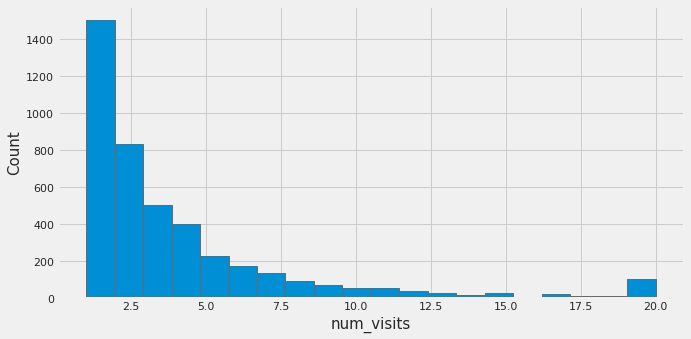

In [133]:
var='num_visits'
plt.figure(figsize=(10,5))
plt.hist(cvm[var],bins=20)
# cvm[var].hist(bins=20)
plt.xlabel(var,fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

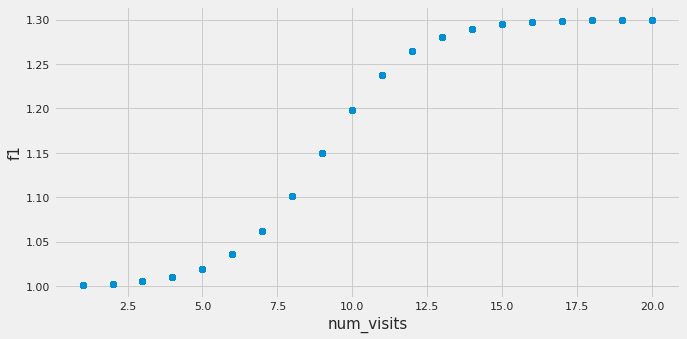

In [134]:
var='num_visits'
mid=9
c=1.5
max_f=1.3
cvm['f1']=cvm[var].apply(lambda x:f_score(x,mid,c,max_f))
plt.figure(figsize=(10,5))
plt.scatter(data=cvm,x=var,y='f1')
plt.xlabel(var,fontsize=15)
plt.ylabel('f1',fontsize=15)
# cvm.plot.scatter(var,'f1')
plt.show()

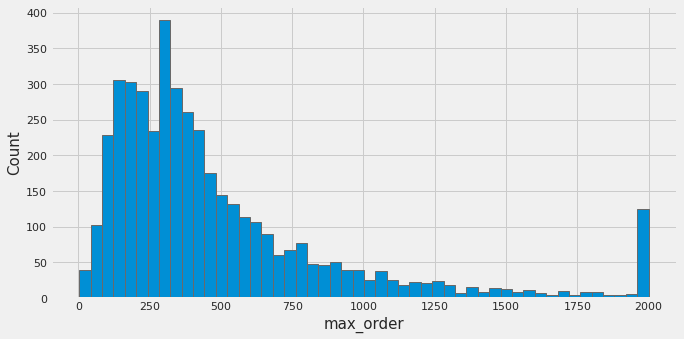

In [135]:
var='max_order'
plt.figure(figsize=(10,5))
plt.hist(cvm[var],bins=50)
plt.xlabel(var,fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

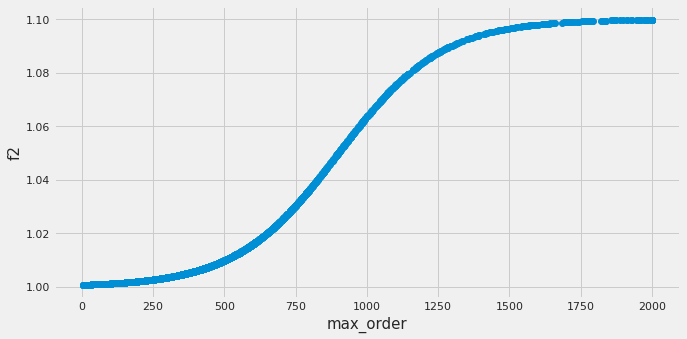

In [136]:
var='max_order'
mid=900
c=180
max_f=1.1
cvm['f2']=cvm[var].apply(lambda x:f_score(x,mid,c,max_f))
plt.figure(figsize=(10,5))
plt.scatter(data=cvm,x=var,y='f2')
plt.xlabel(var,fontsize=15)
plt.ylabel('f2',fontsize=15)
plt.show()

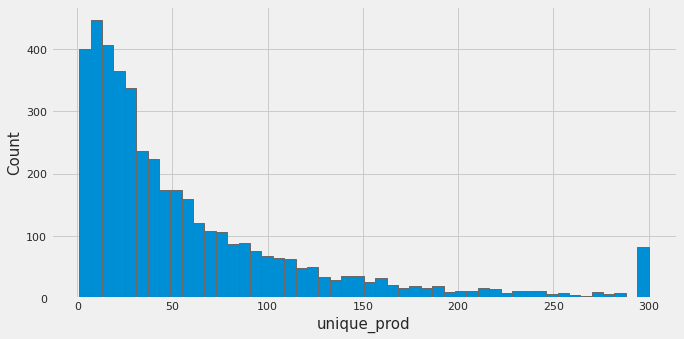

In [137]:
var='unique_prod'
plt.figure(figsize=(10,5))
plt.hist(cvm[var],bins=50)
plt.xlabel(var,fontsize=15)
plt.ylabel('Count',fontsize=15)
plt.show()

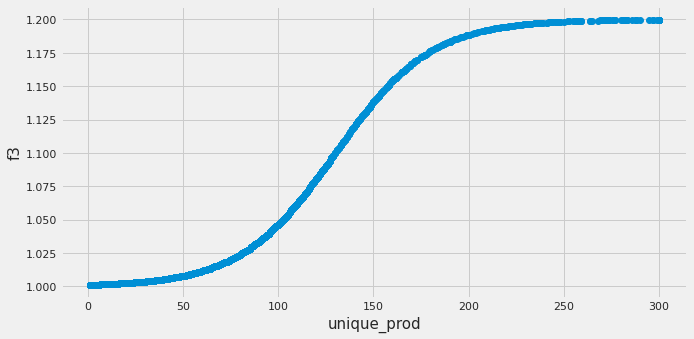

In [138]:
var='unique_prod'
mid=130
c=25
max_f=1.2
cvm['f3']=cvm[var].apply(lambda x:f_score(x,mid,c,max_f))
plt.figure(figsize=(10,5))
plt.scatter(data=cvm,x=var,y='f3')
plt.xlabel(var,fontsize=15)
plt.ylabel('f3',fontsize=15)
plt.show()

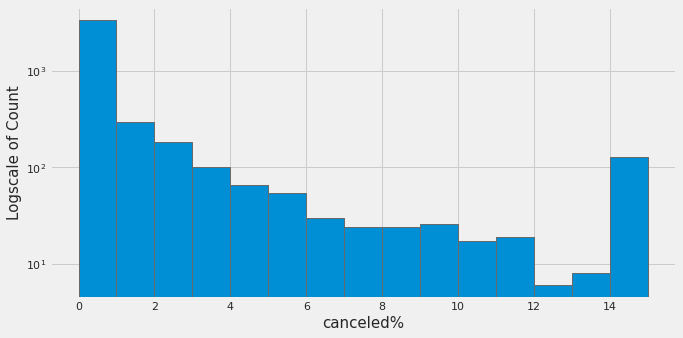

In [139]:
var='canceled%'
plt.figure(figsize=(10,5))
plt.hist(cvm[var],bins=15)
plt.xlabel(var,fontsize=15)
plt.ylabel('Logscale of Count',fontsize=15)
plt.yscale('log')
plt.show()

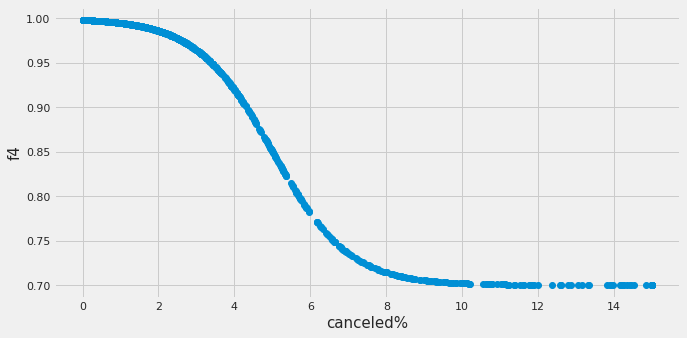

In [140]:
var='canceled%'
mid=5
c=1
max_f=0.7
cvm['f4']=cvm[var].apply(lambda x:f_score(x,mid,c,max_f))
plt.figure(figsize=(10,5))
plt.scatter(data=cvm,x=var,y='f4')
plt.xlabel(var,fontsize=15)
plt.ylabel('f4',fontsize=15)
plt.show()

In [141]:
cvm['CVM']=cvm['sum']*cvm['f1']*cvm['f2']*cvm['f3']*cvm['f4']
cvm.describe()

,sum,num_visits,max_order,unique_prod,canceled%,f1,f2,f3,f4,CVM
count,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000,4324.000000
mean,1908.445201,3.820768,492.345227,58.915125,1.231546,1.035607,1.017575,1.030046,0.972626,2496.838060
std,8286.392597,4.139710,424.325268,64.092995,3.091486,0.078154,0.027634,0.054734,0.074182,13306.043676
min,2.900000,1.000000,2.900000,1.000000,0.000000,1.001441,1.000680,1.001142,0.700014,2.036863
25%,299.975000,1.000000,215.657500,16.000000,0.000000,1.001441,1.002184,1.002071,0.995782,294.541635
50%,652.405000,2.000000,357.990000,35.000000,0.000000,1.002795,1.004692,1.004376,0.997992,652.078382
75%,1610.457500,5.000000,599.542500,78.000000,0.749739,1.019491,1.015853,1.022211,0.997992,1714.459020
max,278742.020000,20.000000,2000.000000,300.000000,15.000000,1.299804,1.099779,1.199777,0.997992,476959.063087


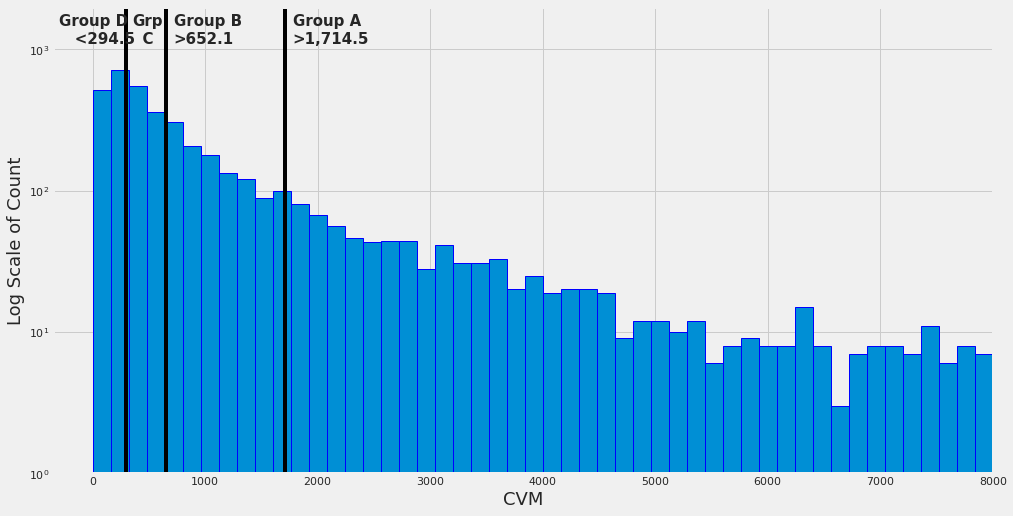

In [142]:
xhigh=8000
temp=cvm[cvm['CVM']<xhigh]['CVM']
plt.figure(figsize=(15,8))
plt.hist(temp,bins=50,edgecolor='blue')
plt.yscale('log')
plt.ylim(1,2000)
plt.xlim(-350,xhigh)
plt.axvline(cvm['CVM'].quantile(0.25),color='black',linewidth=4)
plt.axvline(cvm['CVM'].quantile(0.5),color='black',linewidth=4)
plt.axvline(cvm['CVM'].quantile(0.75),color='black',linewidth=4)
plt.annotate(f"Group D\n   <{cvm['CVM'].quantile(0.25):.1f}",
             (-300,1100),fontweight='bold',fontsize=15)
plt.annotate('Grp\n  C',(350,1100),fontweight='bold',fontsize=15)
plt.annotate(f"Group B\n>{cvm['CVM'].quantile(0.5):.1f}",
             (720,1100),fontweight='bold',fontsize=15)
plt.annotate(f"Group A\n>{cvm['CVM'].quantile(0.75):,.1f}",
             (1780,1100),fontweight='bold',fontsize=15)
plt.xlabel('CVM',fontsize=18)
plt.ylabel('Log Scale of Count',fontsize=18)
plt.savefig('value_groups.png')
plt.show()

It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (** mean **), the total sum spent by the clients (** sum **) or the total number of visits made (** count **).



In [143]:
df_cleaned['InvoiceDateNew'] = df_cleaned['InvoiceDate'].dt.date

In [144]:
df_cleaned['InvoiceDateNew'] = df_cleaned['InvoiceDate'].dt.date

In [145]:
groupby=df_cleaned.groupby('CustomerID').count()['InvoiceNo']

In [146]:
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Month,...,TotalPrice,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,CanceledValue,InvoiceDateNew
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,0,12,...,15.30,1,0.00,15.3,0.0,0.0,0.0,0.0,0.0,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,12,...,20.34,0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,0,12,...,22.00,0,22.00,0.0,0.0,0.0,0.0,0.0,0.0,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,12,...,20.34,0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,0,12,...,20.34,0,20.34,0.0,0.0,0.0,0.0,0.0,0.0,2010-12-01


In [147]:
df_cleaned['Adjusted_Quantity']=df_cleaned['Quantity']-df_cleaned['QuantityCanceled']
df_cleaned.sort_values('Adjusted_Quantity')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCanceled,Month,...,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,CanceledValue,InvoiceDateNew,Adjusted_Quantity
331601,566020,22486,PLASMATRONIC LAMP,1,2011-09-08 12:47:00,12.75,13925,United Kingdom,1,9,...,5,0.0,0.0,0.0,0.00,0.00,0.0,12.75,2011-09-08,0
144525,548747,22423,REGENCY CAKESTAND 3 TIER,8,2011-04-04 12:17:00,12.75,15223,United Kingdom,8,4,...,2,0.0,0.0,0.0,0.00,0.00,0.0,102.00,2011-04-04,0
76527,542627,22937,BAKING MOULD CHOCOLATE CUPCAKES,6,2011-01-31 09:51:00,2.55,14426,United Kingdom,6,1,...,1,0.0,0.0,0.0,0.00,0.00,0.0,15.30,2011-01-31,0
76526,542627,21977,PACK OF 60 PINK PAISLEY CAKE CASES,24,2011-01-31 09:51:00,0.55,14426,United Kingdom,24,1,...,4,0.0,0.0,0.0,0.00,0.00,0.0,13.20,2011-01-31,0
76525,542627,22718,CARD CAT AND TREE,12,2011-01-31 09:51:00,0.42,14426,United Kingdom,12,1,...,4,0.0,0.0,0.0,0.00,0.00,0.0,5.04,2011-01-31,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270885,560599,18007,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,3186,2011-07-19 17:04:00,0.06,14609,United Kingdom,0,7,...,4,0.0,0.0,0.0,0.00,191.16,0.0,0.00,2011-07-19,3186
97432,544612,22053,EMPIRE DESIGN ROSETTE,3906,2011-02-22 10:43:00,0.82,18087,United Kingdom,0,2,...,3,0.0,0.0,0.0,3202.92,0.00,0.0,0.00,2011-02-22,3906
206121,554868,22197,SMALL POPCORN HOLDER,4300,2011-05-27 10:52:00,0.72,13135,United Kingdom,0,5,...,4,0.0,0.0,0.0,0.00,3096.00,0.0,0.00,2011-05-27,4300
421632,573008,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,4800,2011-10-27 12:26:00,0.21,12901,United Kingdom,0,10,...,4,0.0,0.0,0.0,0.00,1008.00,0.0,0.00,2011-10-27,4800


In [148]:
df_cleaned['Total']=df_cleaned['Adjusted_Quantity']*df_cleaned['UnitPrice']
Cancellation=df_cleaned[df_cleaned['InvoiceNo'].str.contains('C')].groupby('CustomerID').count()['InvoiceNo'].reset_index().rename(columns={'InvoiceNo':'Cancels'})
Cancellation.head()

,CustomerID,Cancels


In [149]:
frequency=pd.DataFrame(df_cleaned.groupby('CustomerID').nunique()['InvoiceNo']).reset_index().rename(columns={'InvoiceNo':'Frequency'})
frequencyadj=pd.merge(frequency,Cancellation,how='left').fillna(0)
frequencyadj['Adjusted_Frequency']=frequencyadj['Frequency']-frequencyadj['Cancels']
frequencyadj['Adjusted_Frequency']=frequencyadj['Adjusted_Frequency'].replace(1,0)
frequencyadj.sort_values('Adjusted_Frequency')

,CustomerID,Frequency,Cancels,Adjusted_Frequency
0,12346,1,0.0,0.0
1524,14424,1,0.0,0.0
1523,14423,1,0.0,0.0
3287,16828,1,0.0,0.0
1520,14420,1,0.0,0.0
...,...,...,...,...
2177,15311,91,0.0,91.0
562,13089,97,0.0,97.0
4008,17841,124,0.0,124.0
1880,14911,198,0.0,198.0


Text(0.5, 1.0, 'Adjusted Frequency Histogram\nin Log Scale')

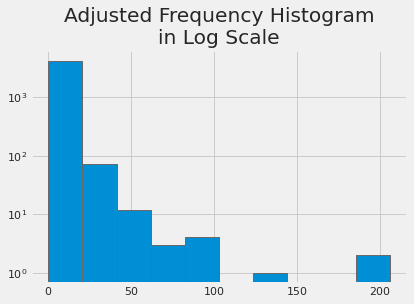

In [150]:
frequencyadj['Adjusted_Frequency'].hist()
plt.yscale('log')
plt.title('Adjusted Frequency Histogram\nin Log Scale')

In [151]:
frequencyadj.describe()

,Frequency,Cancels,Adjusted_Frequency
count,4335.000000,4335.0,4335.000000
mean,4.245675,0.0,3.898270
std,7.636337,0.0,7.797183
min,1.000000,0.0,0.000000
25%,1.000000,0.0,0.000000
50%,2.000000,0.0,2.000000
75%,5.000000,0.0,5.000000
max,206.000000,0.0,206.000000


In [152]:
from datetime import datetime, timedelta
age=pd.DataFrame((max(df_cleaned['InvoiceDate'])+timedelta(1))-df_cleaned.groupby('CustomerID').min()['InvoiceDate']).reset_index().rename(columns={'InvoiceDate':'Customer_Age'})
age['Customer_Age']=pd.to_numeric(age['Customer_Age'].dt.days, downcast='integer')
age

,CustomerID,Customer_Age
0,12346,326
1,12347,367
2,12348,358
3,12349,19
4,12350,310
...,...,...
4330,18280,278
4331,18281,181
4332,18282,126
4333,18283,337


In [153]:
recency=pd.DataFrame(df_cleaned['CustomerID'].unique()).rename(columns={0:'Customer_ID'})
recency

,Customer_ID
0,17850
1,13047
2,12583
3,13748
4,15100
...,...
4330,13436
4331,15520
4332,13298
4333,14569


In [154]:
# this cell is slow
result={}
result
for n in recency['Customer_ID']:
  try:
    outcome=(df_cleaned[df_cleaned['CustomerID']==str(n)]['InvoiceDateNew'].unique()[-1]-df_cleaned[df_cleaned['CustomerID']==str(n)]['InvoiceDateNew'].unique()[-2]).days
    result[n]=outcome
  except:
    result[n]=0

In [155]:
recency1 = pd.DataFrame(list(result.items()),columns = ['CustomerID','Recency']) 
recency1.describe()

,Recency
count,4335.000000
mean,48.022145
std,69.912200
min,0.000000
25%,0.000000
50%,18.000000
75%,66.500000
max,366.000000


In [156]:
from datetime import datetime, timedelta
temp=pd.DataFrame((max(df_cleaned['InvoiceDate'])+timedelta(1))-df_cleaned.groupby('CustomerID').max()['InvoiceDate']).reset_index().rename(columns={'InvoiceDate':'Days_Since_Purchase'})
temp2=pd.DataFrame((max(df_cleaned['InvoiceDate'])+timedelta(1))-df_cleaned.groupby('CustomerID').min()['InvoiceDate']).reset_index().rename(columns={'InvoiceDate':'First_Purchase'})
recency=pd.merge(temp,temp2,how='left')
recency['Days_Since_Purchase'] = pd.to_numeric(recency['Days_Since_Purchase'].dt.days, downcast='integer')
recency['First_Purchase'] = pd.to_numeric(recency['First_Purchase'].dt.days, downcast='integer')
recency=pd.merge(recency1,recency,how='inner')

In [157]:
recency=pd.merge(recency1,recency[['CustomerID','First_Purchase']])

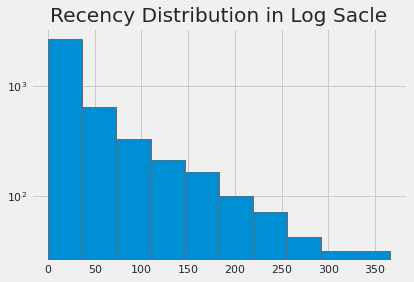

In [158]:
recency['Recency'].hist()
plt.title('Recency Distribution in Log Sacle')
plt.yscale('log')

In [159]:
cancelation=df_cleaned[df_cleaned['InvoiceNo'].str.contains('C')].groupby('CustomerID').count()['InvoiceNo'].reset_index()

In [160]:
cancel_order=df_cleaned[df_cleaned['InvoiceNo'].str.contains('C')]['InvoiceNo']
non_cancel=df_cleaned[df_cleaned['InvoiceNo'].isin(cancel_order)==False]
canceled=df_cleaned[df_cleaned['InvoiceNo'].isin(cancel_order)==True]
non_cancel=non_cancel.groupby('CustomerID').sum()['Total'].reset_index().rename(columns={'Total':'Non_Cancel_Total'})
canceled=canceled.groupby('CustomerID').sum()['Total'].reset_index().rename(columns={'Total':'Cancel_Total'})
totaldf=pd.merge(non_cancel,canceled,how='left').fillna(0)
totaldf['Adjusted_Total']=totaldf['Non_Cancel_Total']-totaldf['Cancel_Total']
totaldf=totaldf[['CustomerID','Adjusted_Total']]
totaldf.describe()

,Adjusted_Total
count,4335.000000
mean,1903.602549
std,8276.427249
min,0.000000
25%,298.660000
50%,650.410000
75%,1601.110000
max,278742.020000


Text(0.5, 1.0, 'Adjusted Total Amount Distribution')

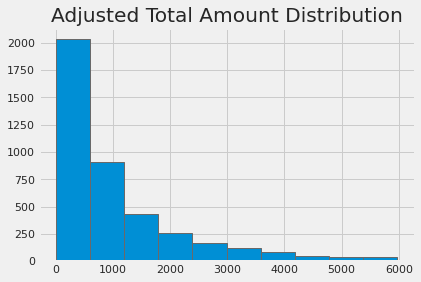

In [161]:
plt.hist(totaldf[totaldf['Adjusted_Total']<=6000]['Adjusted_Total'])
plt.title('Adjusted Total Amount Distribution')

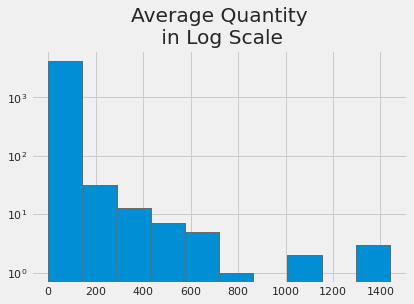

In [162]:
quantity=df_cleaned.groupby('CustomerID').mean()['Adjusted_Quantity'].reset_index().rename(columns={'Adjusted_Quantity':'Average_Quantity'})
quantity.describe()
quantity[quantity['Average_Quantity']<1500].hist('Average_Quantity')
plt.title('Average Quantity\n in Log Scale')
plt.yscale("log")

Text(0.5, 1.0, 'Average Quantity Distribution')

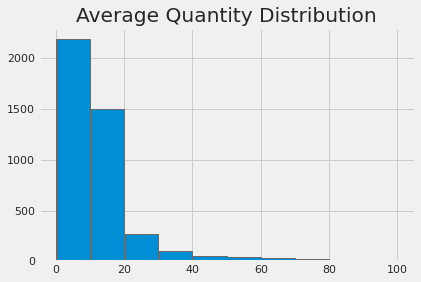

In [163]:
quantity[quantity['Average_Quantity']<=100].hist('Average_Quantity')
plt.title('Average Quantity Distribution')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'F(Recency) Transition Graph\nMidpoint 125 Spread 25')

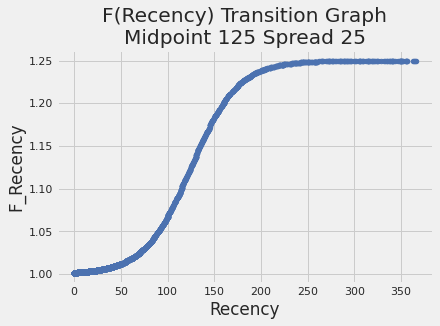

In [164]:
nmid_f1=125
c_f1=25
recency['F_Recency']=1+(1.25-1)/(1+np.exp(-(recency['Recency']-nmid_f1)/c_f1))
recency[recency['Recency']<=500].plot.scatter('Recency','F_Recency')
plt.title('F(Recency) Transition Graph\nMidpoint 125 Spread 25')

In [165]:
frequency=df_cleaned.groupby('CustomerID').nunique('InvoiceNo')['InvoiceNo'].reset_index().rename(columns={'InvoiceNo':'Frequency'})
frequency['Frequency']=frequency['Frequency']-1
frequency
recency=recency[['CustomerID','Recency','F_Recency']]
recency.max()

CustomerID    18287.000000
Recency         366.000000
F_Recency         1.249984
dtype: float64

In [166]:
frequency.describe()

,Frequency
count,4335.000000
mean,3.245675
std,7.636337
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,205.000000


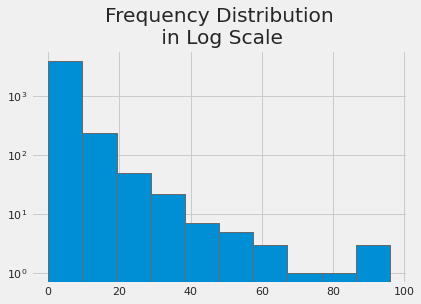

In [167]:
frequency[frequency['Frequency']<=100].hist()
plt.title('Frequency Distribution\n in Log Scale')
plt.yscale('log')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'F(Frequency) Transition Graph\nMidpoint 20 Spread 5')

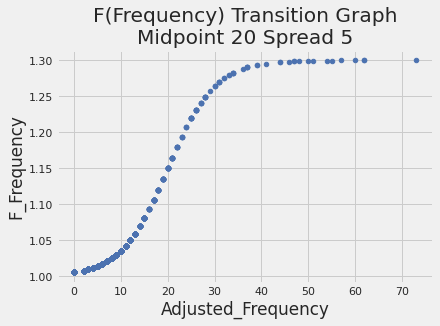

In [168]:
nmid_f1=20
c_f1=5
frequencyadj['F_Frequency']=1+(1.3-1)/(1+np.exp(-(frequencyadj['Adjusted_Frequency']-nmid_f1)/c_f1))
frequencyadj[frequencyadj['Adjusted_Frequency']<=80].plot.scatter('Adjusted_Frequency','F_Frequency')
plt.title('F(Frequency) Transition Graph\nMidpoint 20 Spread 5')

In [169]:
data=pd.merge(frequency[['CustomerID','Frequency']],recency)
data=pd.DataFrame(data)
data=pd.merge(data,totaldf,how='inner')
data=pd.merge(data,frequencyadj[['CustomerID','Adjusted_Frequency','F_Frequency']],how='inner')
data

,CustomerID,Frequency,Recency,F_Recency,Adjusted_Total,Adjusted_Frequency,F_Frequency
0,12346,0,0,1.001673,0.00,0.0,1.005396
1,12347,6,37,1.007187,4310.00,7.0,1.020742
2,12348,3,173,1.218035,1437.24,4.0,1.011750
3,12349,0,0,1.001673,1457.55,0.0,1.005396
4,12350,0,0,1.001673,294.40,0.0,1.005396
...,...,...,...,...,...,...,...
4330,18280,0,0,1.001673,180.60,0.0,1.005396
4331,18281,0,0,1.001673,80.82,0.0,1.005396
4332,18282,1,119,1.110072,176.60,2.0,1.007979
4333,18283,15,6,1.002123,2039.58,16.0,1.093008


count    4335.000000
mean        3.245675
std         7.636337
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max       205.000000
Name: Frequency, dtype: float64
0.34740484429065743


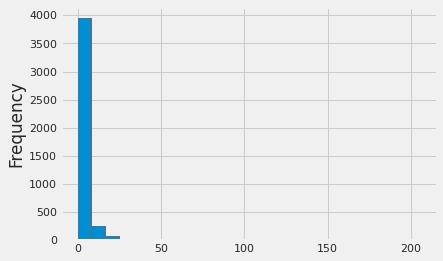

In [170]:
data['Frequency'].plot(kind='hist', bins=25)
print(data['Frequency'].describe())
print(sum(data['Frequency'] == 0)/float(len(data)))

In [171]:
data=pd.merge(data,age,how='inner')
data['F_Frequency'].max()

1.3

In [172]:
frequencyadj=frequencyadj[['CustomerID','Adjusted_Frequency']]
frequencyadj['Adjusted_Frequency']=frequencyadj['Adjusted_Frequency'].replace(1,0)

In [173]:
data=pd.merge(data,quantity,how='inner')

In [174]:
data['CVM'] = cvm['CVM']

In [175]:
data['CVM_Group']=np.nan
for n in range(0,len(data)):
  if data['CVM'][n]<=318.8:
    data['CVM_Group'][n]=1
  elif data['CVM'][n]<=730.1:
    data['CVM_Group'][n]=2
  elif data['CVM'][n]<=1785.8:
    data['CVM_Group'][n]=3
  else:
    data['CVM_Group'][n]=4

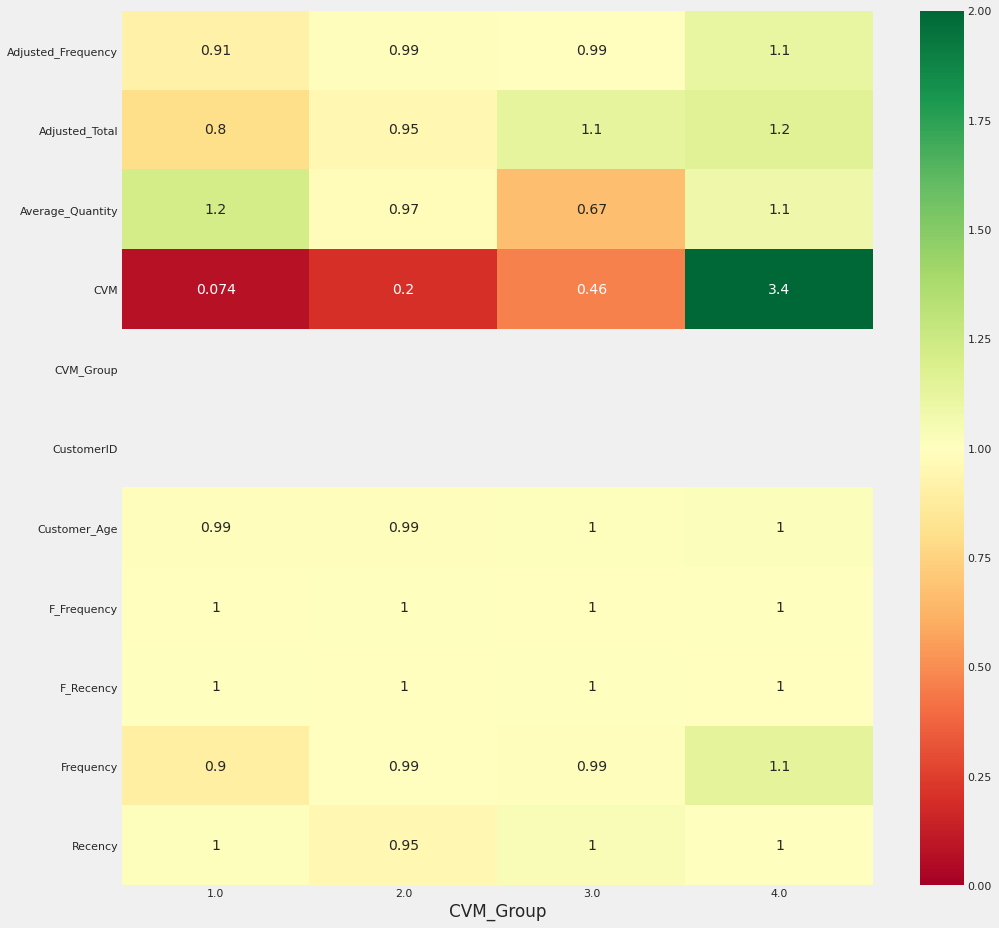

In [176]:
field_means = data.mean()
Knn_table = data.groupby('CVM_Group').mean()
Knn_norm_table = Knn_table / field_means
Knn_norm_table_transpose = Knn_norm_table.transpose()
plt.figure(figsize=(15,15))
sns.heatmap(Knn_norm_table_transpose, cmap='RdYlGn', annot=True, vmin=0, vmax=2)

In [177]:
len(data[data['Recency']==0])/len(data)

0.3596309111880046

In [178]:
for n in range(0,len(data)):
  if data['Adjusted_Frequency'][n]==0:
    data['Recency'][n]=0

In [179]:
from lifetimes import BetaGeoFitter
from scipy.special import logsumexp
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['Adjusted_Frequency'], data['Recency'], data['Customer_Age'],)
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4335 subjects, a: 10.60, alpha: 0.30, b: 63.87, r: 0.16>


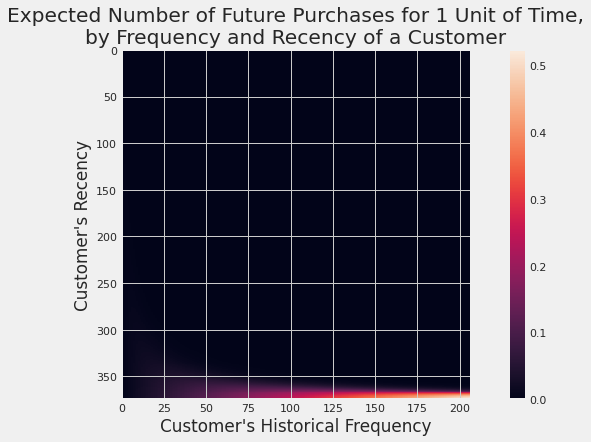

In [180]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,6))
plot_frequency_recency_matrix(bgf)

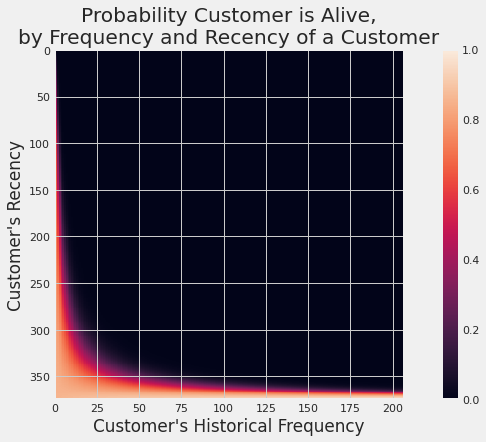

In [181]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,6))
plot_probability_alive_matrix(bgf)

In [182]:
from lifetimes.plotting import *
from lifetimes.utils import *
# from lifetimes.estimation import *

In [183]:
cancel_order=df_cleaned[df_cleaned['InvoiceNo'].str.contains('C')]
non_cancel=df_cleaned[df_cleaned['InvoiceNo'].isin(cancel_order)==False]
temp=non_cancel.groupby('CustomerID').count()['InvoiceNo'].reset_index()
temp['One_Timer']=np.nan
for n in range(0,len(temp)):
  if temp['InvoiceNo'][n]==1:
    temp['One_Timer'][n]='One_Time'
  else:
    temp['One_Timer'][n]='Repeat'
temp=temp[['CustomerID','One_Timer']]
data=pd.merge(data,temp,how='inner')

Text(0.5, 1.0, 'One Time Purchaser v.s. Repeat Customers\nTotal Amount Comparison')

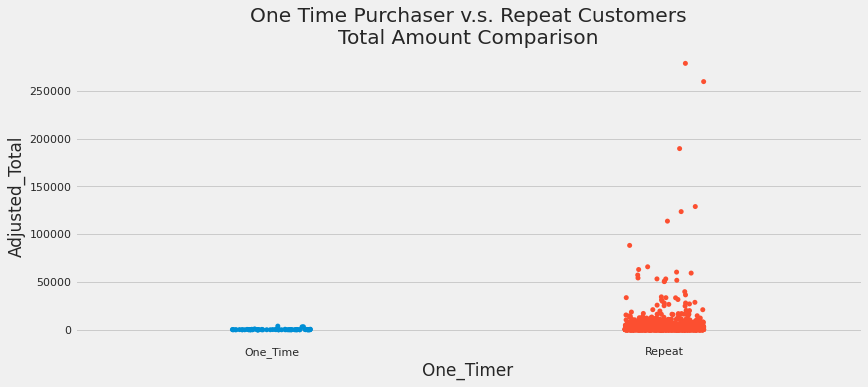

In [184]:
a=sns.catplot(x="One_Timer", y="Adjusted_Total", data=data)
a.fig.set_figwidth(15)
a.fig.set_figheight(5)
plt.title('One Time Purchaser v.s. Repeat Customers\nTotal Amount Comparison')

In [185]:
df_new=pd.merge(df_cleaned,temp,how='left')
df_new['Weekday']=df_new['InvoiceDate'].dt.day_name()
weekday=df_new.groupby(['CustomerID','Weekday']).sum().reset_index()

Text(0.5, 1.0, 'One Time Customer v.s. Repeat Customer\nComparison (without Returns)')

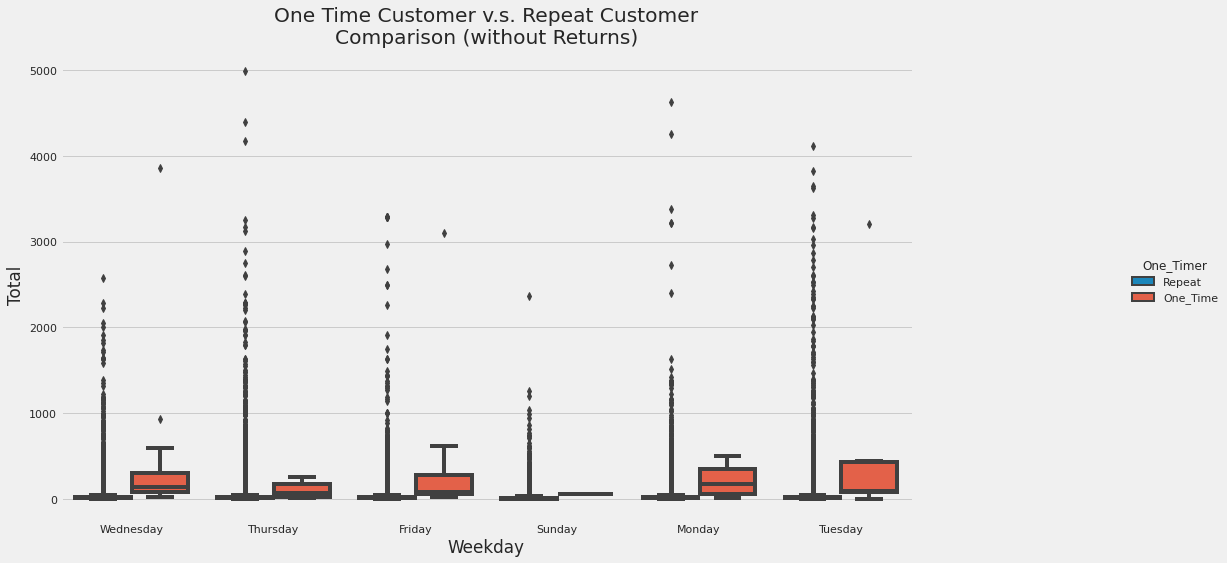

In [186]:
df_new=df_new[df_new['Total']>0]
df_new=df_new[df_new['Total']<=6000]
g=sns.catplot(x="Weekday", y="Total", hue="One_Timer", kind="box", data=df_new)

g.fig.set_figwidth(20)
g.fig.set_figheight(8)
plt.title('One Time Customer v.s. Repeat Customer\nComparison (without Returns)')

In [187]:
citizen=df_cleaned[['CustomerID','Country']].drop_duplicates()
data_citizen=pd.merge(citizen,data,how='right')

In [188]:
top10=pd.DataFrame(df_new.groupby('Country').count()['InvoiceNo'].reset_index().sort_values('InvoiceNo',ascending=False)[:6]['Country'])
df_top10=pd.merge(data_citizen,top10,how='inner')

Text(0.5, 1.0, 'Customer Value Distribution Among Top 6 Countries\nwith Most Orders Placed')

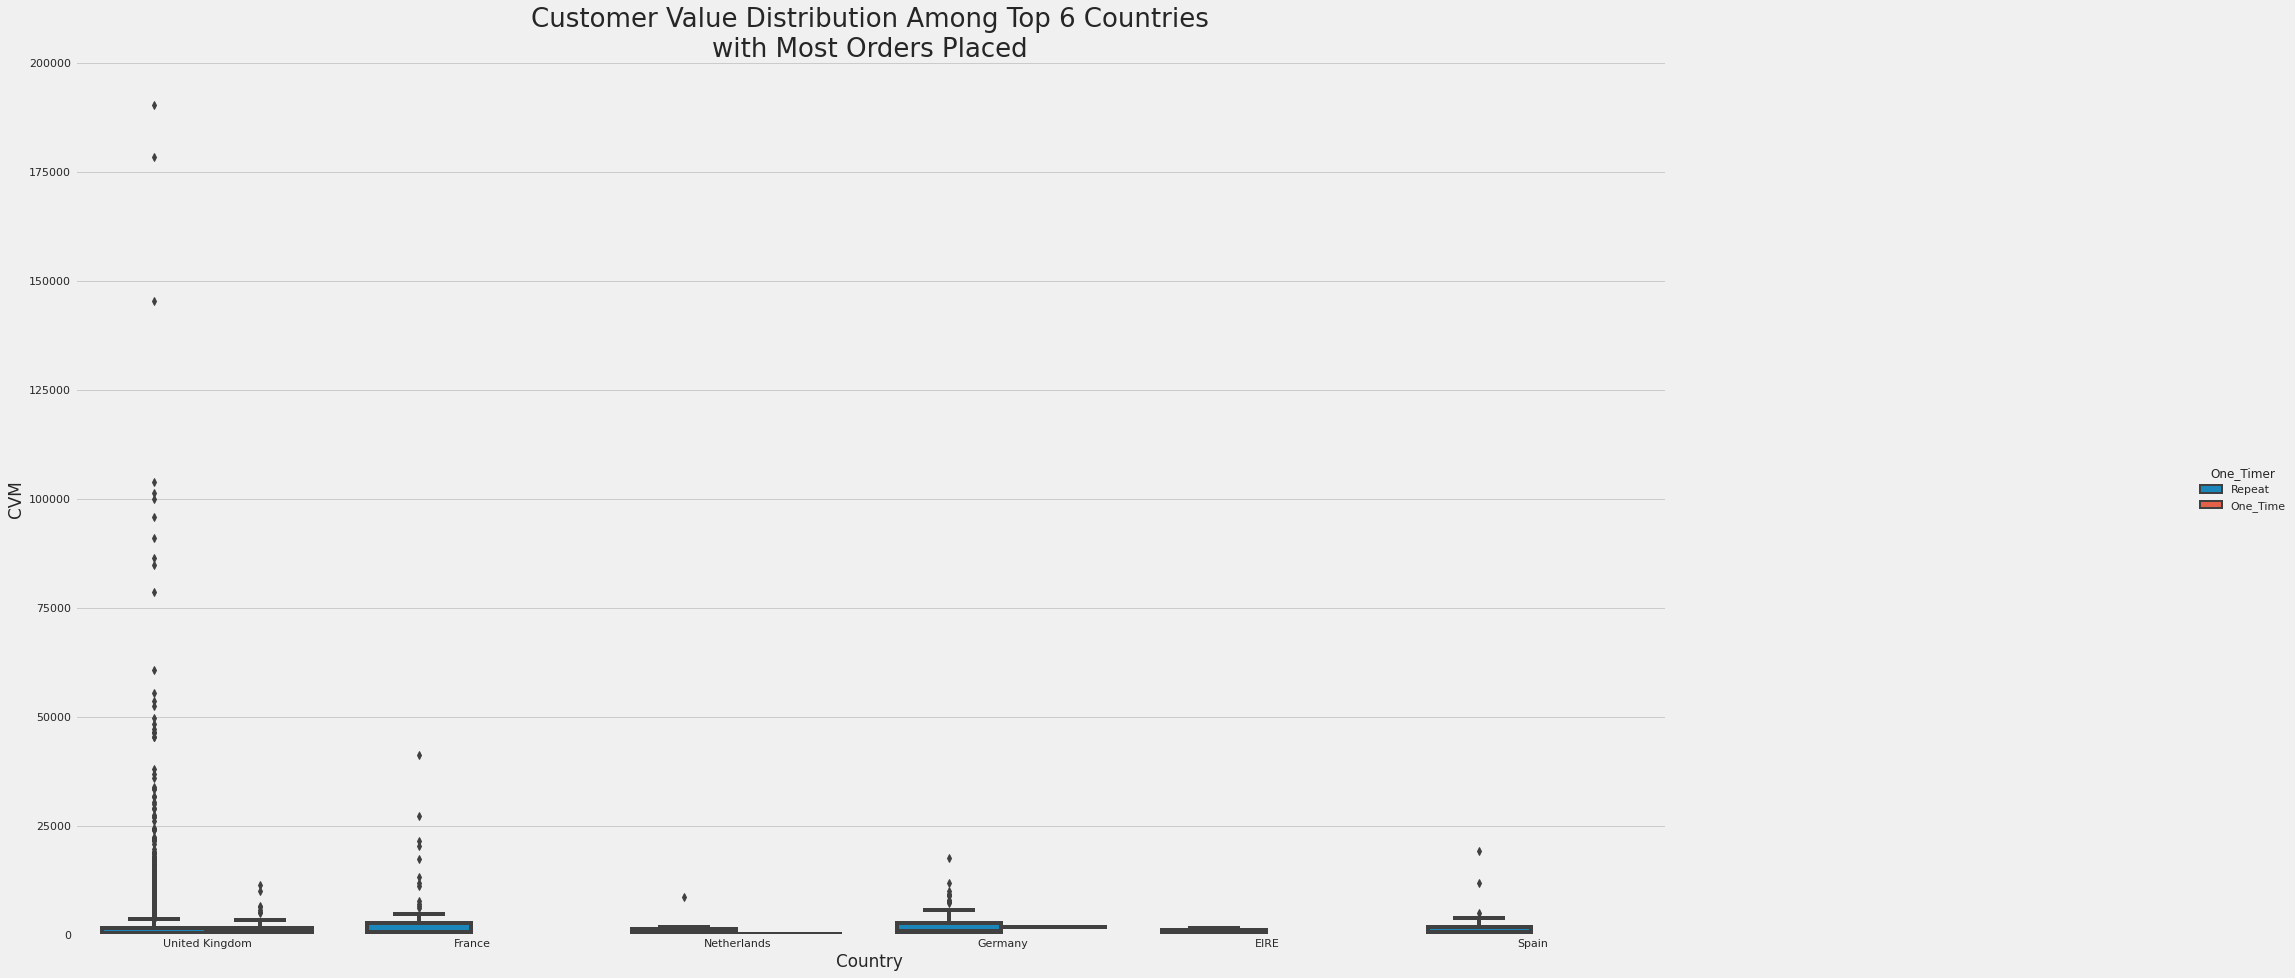

In [189]:
g = sns.catplot(data=df_top10, x='Country', kind="box",
                y='CVM', hue='One_Timer')
g.fig.set_figwidth(40)
g.fig.set_figheight(15)
plt.ylim(0,200000)
plt.title('Customer Value Distribution Among Top 6 Countries\nwith Most Orders Placed',fontsize=26)

In [190]:
df_cleaned[df_cleaned['Country']=='EIRE'].groupby('CustomerID').count()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,QuantityCanceled,Month,Weekday,...,categ_0,categ_1,categ_2,categ_3,categ_4,categ_5,CanceledValue,InvoiceDateNew,Adjusted_Quantity,Total
CustomerID,,,,,,,,,,,,,,,,,,,,,
14016,160,160,160,160,160,160,160,160,160,160,...,160,160,160,160,160,160,160,160,160,160
14156,1382,1382,1382,1382,1382,1382,1382,1382,1382,1382,...,1382,1382,1382,1382,1382,1382,1382,1382,1382,1382
14911,5586,5586,5586,5586,5586,5586,5586,5586,5586,5586,...,5586,5586,5586,5586,5586,5586,5586,5586,5586,5586


In [191]:
top10=pd.DataFrame(df_new.groupby('Country').nunique()['CustomerID'].reset_index().sort_values('CustomerID',ascending=False)[:6]['Country'])
df_top10=pd.merge(data_citizen,top10,how='inner')

Text(0.5, 1.0, 'Customer Value Distribution Among Top 6 Countries\nwith Most Customers Capped at $20,000 CVM')

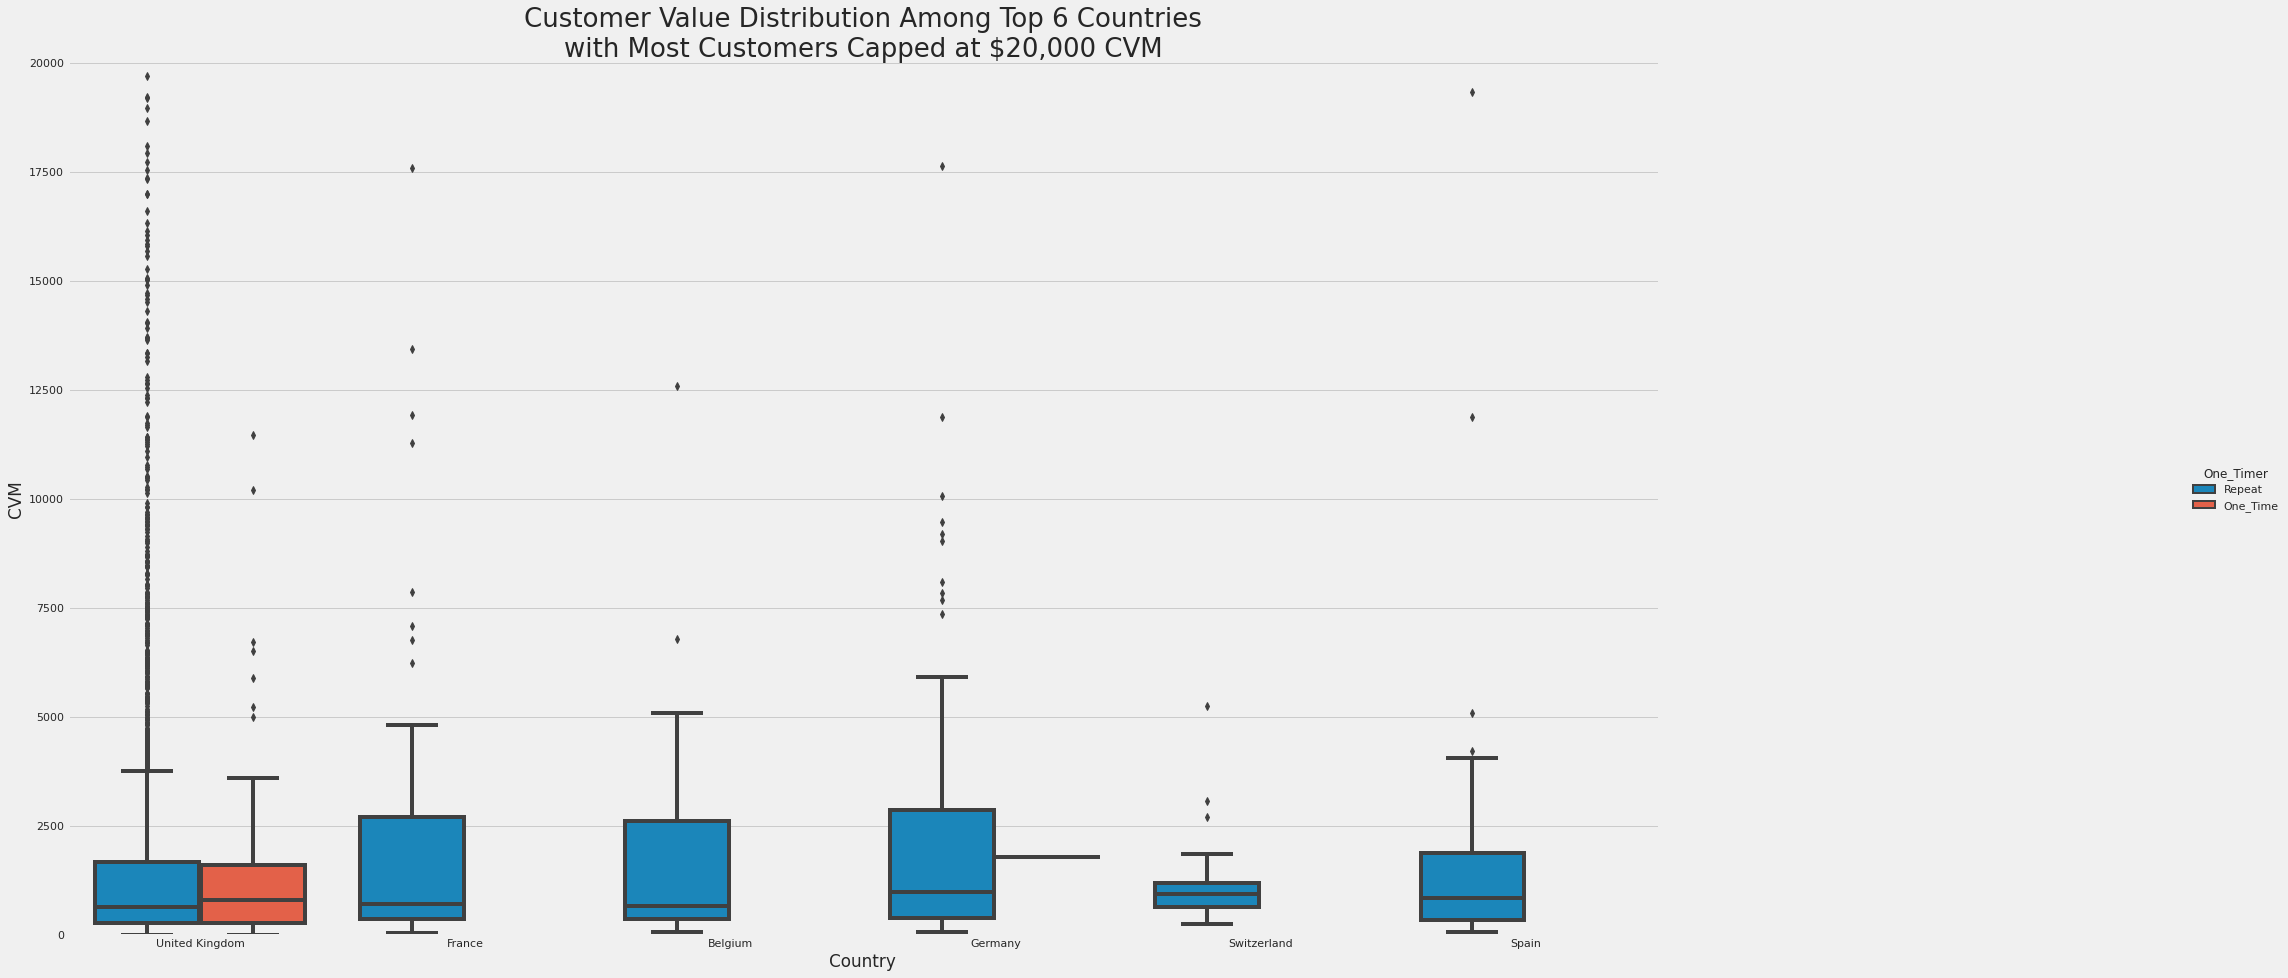

In [192]:
g = sns.catplot(data=df_top10, x='Country', kind="box",
                y='CVM', hue='One_Timer')
plt.ylim(0,20000)
g.fig.set_figwidth(40)
g.fig.set_figheight(15)
plt.title('Customer Value Distribution Among Top 6 Countries\nwith Most Customers Capped at $20,000 CVM',fontsize=26)

In [193]:
data.groupby(['CVM_Group','One_Timer']).mean()['Adjusted_Total']

CVM_Group  One_Timer
1.0        One_Time      179.437391
           Repeat       1555.787916
2.0        One_Time      427.519167
           Repeat       1823.729670
3.0        One_Time      153.228636
           Repeat       2193.083067
4.0        One_Time      543.377059
           Repeat       2241.400280
Name: Adjusted_Total, dtype: float64

Text(0.5, 1.0, 'Customer Value Measure by 25% Percentile')

<Figure size 720x360 with 0 Axes>

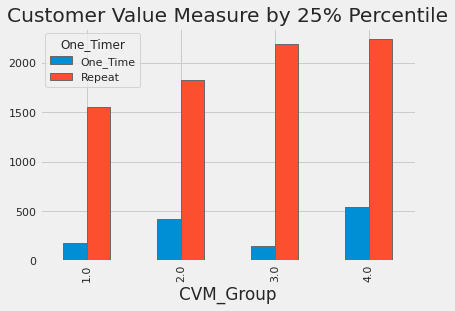

In [194]:
plt.figure(figsize=(10,5))
p=data.groupby(['CVM_Group','One_Timer']).mean()['Adjusted_Total'].unstack().plot(kind='bar')
plt.title('Customer Value Measure by 25% Percentile')

In [195]:
df_new.groupby(['Weekday','One_Timer']).sum()['Total']

Weekday    One_Timer
Friday     One_Time        5565.53
           Repeat       1211416.03
Monday     One_Time        1688.27
           Repeat       1291073.72
Sunday     One_Time          52.00
           Repeat        767458.30
Thursday   One_Time        1933.05
           Repeat       1885193.12
Tuesday    One_Time        5365.72
           Repeat       1534339.21
Wednesday  One_Time        7261.16
           Repeat       1527086.82
Name: Total, dtype: float64

## New section. Item Co-occurance Analysis and Recommendation
inspired by https://pbpython.com/market-basket-analysis.html#:~:text=Association%20rules%20are%20normally%20written,%7BBeer%7D%20is%20the%20consequent.

The goal of constructing an association rules framework is to find interesting sales relations between various items within the transaction dataset. Ultimately, it will help us discover items people will most likely to buy given the goods in the previous purchase. Consider a scenario where the transaction data is organized into a large matrix which contains the transaction IDs and the names of purchased item. In each entry a value of 1 is assigned if the item is present in the corresponding transaction, 0 if otherwise. For example, if an association rule is defined as {Lamps, Bedside Tables} => {Beds}, indicating that if lamps and bedside tables are purchased, customers will also buy beds.

### Association Rules Metrics
Support: indicates how frequently an antecedent X (i.e.,{Lamps & Bedside Tables}) has appeared in the whole dataset. 

Confidence: indicates how often the rule turns out to be true, in our case, what proportion of the antecedent X {Lamps & Bedside Tables} has resulted in the purchase of Y (Beds). 

Lift: denotes the ratio of: observed Support/expected Support if X and Y are independent. If Lift = 1, this would mean that no rule can be applied since the occurrences of the two events are independent. If Lift > 1, it implies the degree to which the Y is dependent on X. If Lift < 1, then it means X and Y are substitute to each other (i.e., the presence of one itemset negatively impacts the presence of the other)

Conviction: can be interpreted as the ratio of the expected frequency that X occurs without Y (i.e, the frequency that the rule makes an incorrect prediction) if X and Y were independent divided by the observed frequency of incorrect predictions.

### A simple implementation on the dataset

In [196]:
ar_df = (df_cleaned.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo'))

def encoding(x):
    if x <= 0:return 0      
    if x >= 1:return 1
        
itemsets = ar_df.applymap(encoding)
frequent_sets = apriori(itemsets, min_support=0.025, use_colnames=True)
assoc_rules = association_rules(frequent_sets, min_threshold=0.4)

In [197]:
frequent_sets

,support,itemsets
0,0.039446,(6 RIBBONS RUSTIC CHARM)
1,0.025319,(60 CAKE CASES VINTAGE CHRISTMAS)
2,0.035697,(60 TEATIME FAIRY CAKE CASES)
3,0.027221,(72 SWEETHEART FAIRY CAKE CASES)
4,0.042869,(ALARM CLOCK BAKELIKE GREEN)
...,...,...
144,0.025211,"(LUNCH BAG PINK POLKADOT, LUNCH BAG BLACK SKU..."
145,0.028090,"(LUNCH BAG BLACK SKULL., LUNCH BAG RED RETROS..."
146,0.028416,"(LUNCH BAG PINK POLKADOT, LUNCH BAG RED RETROS..."
147,0.025374,"(LUNCH BAG RED RETROSPOT, LUNCH BAG SPACEBOY D..."


In [198]:
#the following item antecedent and consequents pairs ordered by confidence
#can be of help to formulate sales strategies such as item bundling
assoc_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.047650,0.042869,0.028797,0.604333,14.097273,0.026754,2.419032
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.042869,0.047650,0.028797,0.671736,14.097273,0.026754,2.901174
2,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.034501,0.041076,0.025156,0.729134,17.750937,0.023739,3.540214
3,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.041076,0.034501,0.025156,0.612434,17.750937,0.023739,2.491184
4,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.042543,0.037544,0.029394,0.690932,18.403197,0.027797,3.114062
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.037544,0.042543,0.029394,0.782923,18.403197,0.027797,4.410686
6,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.047324,0.086933,0.029666,0.626866,7.210914,0.025552,2.447020
7,(LUNCH BAG PINK POLKADOT),(LUNCH BAG BLACK SKULL.),0.050584,0.057158,0.025211,0.498389,8.719436,0.022319,1.879626
8,(LUNCH BAG BLACK SKULL.),(LUNCH BAG PINK POLKADOT),0.057158,0.050584,0.025211,0.441065,8.719436,0.022319,1.698615
9,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.057158,0.069981,0.028090,0.491445,7.022549,0.024090,1.828748


### Building Recommender System Using Scikit-Surprise

In this section, we use the lifetime quantity a customer buys an item as the metric to build a recommender system that gives recommendation based on the items a customer buys. Specifically we use the scikit-surprise package for this task. More info on the package can be found at http://surpriselib.com/

In [199]:
from surprise import SVD,accuracy, Dataset, Reader
from surprise.model_selection import cross_validate,train_test_split

In [200]:
rs_df = pd.DataFrame(df_cleaned.groupby(['CustomerID','StockCode'])['Quantity'].sum()).reset_index()
rs_df

,CustomerID,StockCode,Quantity
0,12346,23166,74215
1,12347,16008,24
2,12347,17021,36
3,12347,20665,6
4,12347,20719,40
...,...,...,...
266221,18287,84920,4
266222,18287,85039A,96
266223,18287,85039B,120
266224,18287,85040A,48


In [201]:
reader = Reader()
rs_df_matrix = Dataset.load_from_df(rs_df[['CustomerID', 'StockCode', 'Quantity']], reader)

In [202]:
trainset, testset = train_test_split(rs_df_matrix, test_size=0.25)

In [203]:
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)

In [204]:
accuracy.rmse(predictions)

RMSE: 93.7919


93.79185369712984

In [205]:
#let's take a close look at how this can make recommendations for a specific customer
#for the sake of illustration, we will use customer id 13268
iids = rs_df['StockCode'].unique()
iids13268 = rs_df.loc[rs_df.CustomerID=='13268','StockCode']
#remove the items that 13268 has already purchased
iids_to_pred = np.setdiff1d(iids, iids13268)
test_df = [['13268',iid, 5] for iid in iids_to_pred] #
predictions = algo.test(testset)
predictions[0]

Prediction(uid='16693', iid='23020', r_ui=2.0, est=5, details={'was_impossible': False})

In [206]:
pred_ratings = np.array([pred.est for pred in predictions])
#find the index of the max predicted rating
i_max = pred_ratings.argmax()
#use this to find the corresponding iid
iid = iids_to_pred[i_max]
print("Top item for customer 13268 has stockcode {0}, with predicted rating {1}".format(iid, pred_ratings[i_max]))

Top item for customer 13268 has stockcode 10002, with predicted rating 5


# New Section: Itemsets Analysis and Customer Buying Habits

### 5.1 Association Rules Mining
This data mining method will find the top co-occurance items and find provide metrics on how strong the found pairs are based on a measure. For example how confident are you, based on the dataset that if a customer buys beer he/she will also buy diapers?

In [207]:
invoices = (df_cleaned.groupby(['InvoiceNo', 'Description'])['Quantity']
                      .sum().unstack().reset_index().fillna(0)
                      .set_index('InvoiceNo'))

#### Formulas for metrics
- support(A->C) = support(A+C) [aka 'support'], range: [0, 1]

- confidence(A->C) = support(A+C) / support(A), range: [0, 1]

- lift(A->C) = confidence(A->C) / support(C), range: [0, inf]

- leverage(A->C) = support(A->C) - support(A)*support(C),
range: [-1, 1]

- conviction = [1 - support(C)] / [1 - confidence(A->C)],
range: [0, inf]

In [208]:
# this cell takes a while
basket_sets = invoices.applymap(lambda x: 1 if x >= 1 else 0)
frequent_itemsets = apriori(basket_sets, min_support=0.02, use_colnames=True)

In [209]:
# below is a list of all frequent itemsets bought by customers
frequent_itemsets

,support,itemsets
0,0.021842,(3 STRIPEY MICE FELTCRAFT)
1,0.039446,(6 RIBBONS RUSTIC CHARM)
2,0.025319,(60 CAKE CASES VINTAGE CHRISTMAS)
3,0.035697,(60 TEATIME FAIRY CAKE CASES)
4,0.027221,(72 SWEETHEART FAIRY CAKE CASES)
...,...,...
237,0.023689,"(ROSES REGENCY TEACUP AND SAUCER , PINK REGENC..."
238,0.024722,"(WHITE HANGING HEART T-LIGHT HOLDER, RED HANGI..."
239,0.022820,"(REGENCY CAKESTAND 3 TIER, ROSES REGENCY TEACU..."
240,0.025428,"(WOODEN PICTURE FRAME WHITE FINISH, WOODEN FRA..."


In [210]:
# below is a list of all frequent itemsets that are a combination of 2 or more items
# bought by customers
frequent_itemsets[frequent_itemsets.itemsets.apply(len) > 1]

,support,itemsets
206,0.028797,"(ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI..."
207,0.021516,"(ALARM CLOCK BAKELIKE RED , ALARM CLOCK BAKELI..."
208,0.023037,"(SPACEBOY LUNCH BOX , DOLLY GIRL LUNCH BOX)"
209,0.025156,"(GARDENERS KNEELING PAD CUP OF TEA , GARDENERS..."
210,0.024993,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY..."
211,0.020321,"(REGENCY CAKESTAND 3 TIER, GREEN REGENCY TEACU..."
212,0.029394,"(ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN..."
213,0.022114,"(HEART OF WICKER SMALL, HEART OF WICKER LARGE)"
214,0.029666,"(JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS..."
215,0.022494,"(JUMBO BAG STRAWBERRY, JUMBO BAG RED RETROSPOT)"


a list of item antecedent and consequents paired rank ordered by confidence store might employ strategies for either bundle these items, or make the pair  of items physically far away from each other instore so customers looking for the second item (to complete the set) needs to walk across the whole store therefore more chances to "accidentally" find new items to buy.

In [211]:
rules = association_rules(frequent_itemsets, min_threshold=0.5)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.047650,0.042869,0.028797,0.604333,14.097273,0.026754,2.419032
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.042869,0.047650,0.028797,0.671736,14.097273,0.026754,2.901174
2,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED ),0.033306,0.047650,0.021516,0.646003,13.557229,0.019929,2.690279
3,(SPACEBOY LUNCH BOX ),(DOLLY GIRL LUNCH BOX),0.038250,0.033469,0.023037,0.602273,17.994853,0.021757,2.430135
4,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX ),0.033469,0.038250,0.023037,0.688312,17.994853,0.021757,3.085613
5,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.034501,0.041076,0.025156,0.729134,17.750937,0.023739,3.540214
6,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.041076,0.034501,0.025156,0.612434,17.750937,0.023739,2.491184
7,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.030209,0.037544,0.024993,0.827338,22.036408,0.023859,5.574223
8,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.037544,0.030209,0.024993,0.665702,22.036408,0.023859,2.900976
9,(GREEN REGENCY TEACUP AND SAUCER),(REGENCY CAKESTAND 3 TIER),0.037544,0.092584,0.020321,0.541245,5.846013,0.016845,1.977996


### Explicit recommender systems
Using the quantity customers buy as an explicit measure of "rating", this factorization model will recommend items based on given customerID.

This recommendation model can help pinpoint specific items to recommend to specific customer.

In [212]:
items = df_cleaned['StockCode'].unique()
items2idx = dict(zip(items, range(len(items))))
idx2item = dict(zip(range(len(items)), items))

In [213]:
# I couldn't get spotlight to run so I commented out the next 6 cells
# interactions = spotlight.Interactions(df_cleaned.CustomerID.values.astype(int),
#                             df_cleaned.StockCode.map(items2idx).values.astype(int),
#                             df_cleaned.Quantity.values.astype(float))

In [214]:
# model = ExplicitFactorizationModel(loss='regression',
#                                    embedding_dim=128,  # latent dimensionality
#                                    n_iter=10,  # number of epochs of training
#                                    batch_size=1024,  # minibatch size
#                                    l2=1e-9,  # strength of L2 regularization
#                                    learning_rate=1e-3,
#                                    use_cuda=torch.cuda.is_available())

In [215]:
# train, test = random_train_test_split(interactions)
# model.fit(train, verbose=True)

In [216]:
# train_rmse = rmse_score(model, train)
# test_rmse = rmse_score(model, test)

# print('Train RMSE {:.3f}, test RMSE {:.3f}'.format(train_rmse, test_rmse))

In [217]:
# Checking for the top 10 predicted items that CustomerID=333 will buy (descending)
# Customer_ID = 333
# probabilities = model.predict(Customer_ID)
# top_10_items = np.argsort(-probabilities)[:10]
# for item in top_10_items:
#   group = idx2item[item]
#   print(df_cleaned.groupby('StockCode')['Description'].get_group(group).iloc[0].title())

In [218]:
# It can be seen, for example, that the first 5 clusters correspond to a strong preponderance of purchases in a particular category of products. Other clusters will differ from basket averages (** mean ), the total sum spent by the clients ( sum ) or the total number of visits made ( count **).

____
## 5. Classification of customers

In this part, the objective will be to adjust a classifier that will classify consumers in the different client categories that were established in the previous section. The objective is to make this classification possible at the first visit. To fulfill this objective, I will test several classifiers implemented in `scikit-learn`. First, in order to simplify their use, I define a class that allows to interface several of the functionalities common to these different classifiers: 

In [219]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))
        

Since the goal is to define the class to which a client belongs and this, as soon as its first visit, I only keep the variables that describe the content of the basket, and do not take into account the variables related to the frequency of visits or variations of the basket price over time:

In [220]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
Y = selected_customers['cluster']

Finally, I randomly split the dataset in train and test sets:

In [221]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

___
### 5.1 Support Vector Machine Classifier (SVC)

The first classifier I use is the SVC classifier. In order to use it, I create an instance of the `Class_Fit` class and then call` grid_search()`. When calling this method, I provide as parameters:
- the hyperparameters for which I will seek an optimal value
- the number of folds to be used for cross-validation

In [222]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 3)
# svc.grid.best_params_

Once this instance is created, I adjust the classifier to the training data:

In [223]:
svc.grid_fit(X = X_train, Y = Y_train)

then I can test the quality of the prediction with respect to the test data:

In [224]:
svc.grid_predict(X_test, Y_test)

Precision: 53.27 % 


___
#### 5.1.1 Confusion matrix

The accuracy of the results seems to be correct. Nevertheless, let us remember that when the different classes were defined, there was an imbalance in size between the classes obtained. In particular, one class contains around 40% of the clients. It is therefore interesting to look at how the predictions and real values compare to the breasts of the different classes. This is the subject of the confusion matrices and to represent them, I use the code of the [sklearn documentation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html):

In [225]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    #_________________________________________________
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    #_________________________________________________
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    #_________________________________________________
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

from which I create the following representation:

Confusion matrix, without normalization


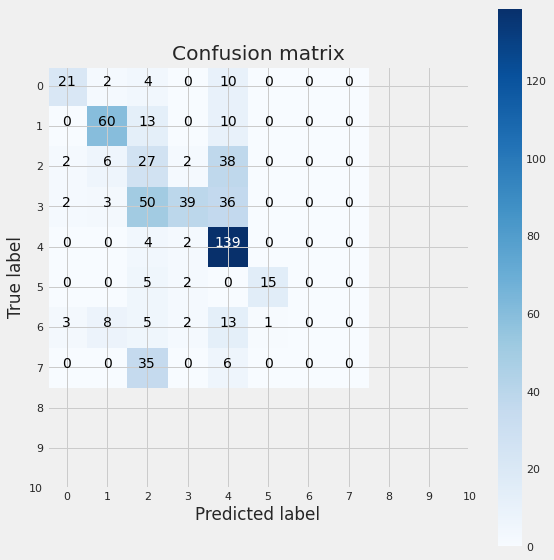

In [226]:
class_names = [i for i in range(11)]
cnf_matrix = confusion_matrix(Y_test, svc.predictions) 
np.set_printoptions(precision=2)
plt.figure(figsize = (8,8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, title='Confusion matrix')

___
#### 5.1.2 Learning curve

A typical way to test the quality of a fit is to draw a learning curve. In particular, this type of curves allow to detect possible drawbacks in the model, linked for example to over- or under-fitting. This also shows to which extent the mode could benefit from a larger data sample. In order to draw this curve, I use the [scikit-learn documentation code again](http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr- self-examples-model-selection-pad-learning-curve-py)

In [227]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 10)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    return plt

from which I represent the leanring curve of the SVC classifier:

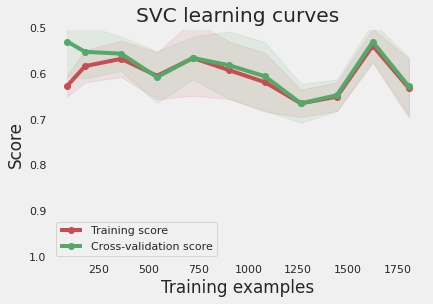

In [228]:
g = plot_learning_curve(svc.grid.best_estimator_,
                        "SVC learning curves", X_train, Y_train, ylim = [1.01, 0.5],
                        cv = 5,  train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                0.6, 0.7, 0.8, 0.9, 1])

On this curve, we can see that the train and cross-validation curves converge towards the same limit when the sample size increases. This is typical of modeling with low variance and proves that the model does not suffer from overfitting. Also, we can see that the accuracy of the training curve is correct which is synonymous of a low bias. Hence the model does not underfit the data.

___
### 5.2 Logistic Regression

I now consider the logistic regression classifier. As before, I create an instance of the `Class_Fit` class, adjust the model on the training data and see how the predictions compare to the real values:

In [229]:
lr = Class_Fit(clf = linear_model.LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-2,2,20)}], Kfold = 3)
lr.grid_fit(X = X_train, Y = Y_train)
lr.grid_predict(X_test, Y_test)
lr.grid.best_params_

Precision: 66.02 % 


{'C': 3.359818286283781}

Then, I plot the learning curve to have a feeling of the quality of the model:

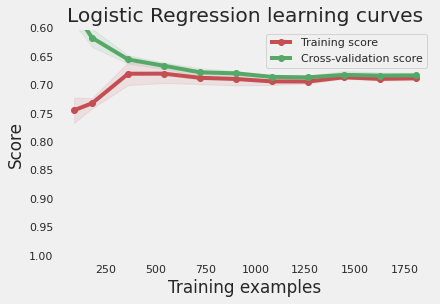

In [230]:
g = plot_learning_curve(lr.grid.best_estimator_, "Logistic Regression learning curves", X_train, Y_train,
                        ylim = [1.01, 0.6], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.3 k-Nearest Neighbors

In [231]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(5,25,1)}], Kfold = 3)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)
knn.grid.best_params_

Precision: 67.61 % 


{'n_neighbors': 9}

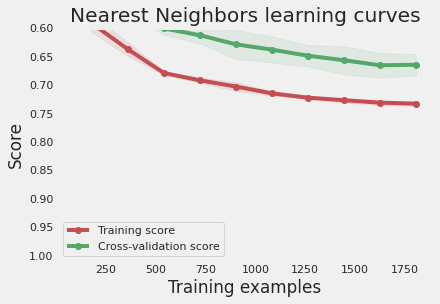

In [232]:
g = plot_learning_curve(knn.grid.best_estimator_, "Nearest Neighbors learning curves", X_train, Y_train,
                        ylim = [1.01, 0.6], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.4 Decision Tree

In [233]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 3)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)
tr.grid.best_params_

Precision: 63.36 % 


{'criterion': 'entropy', 'max_features': 'log2'}

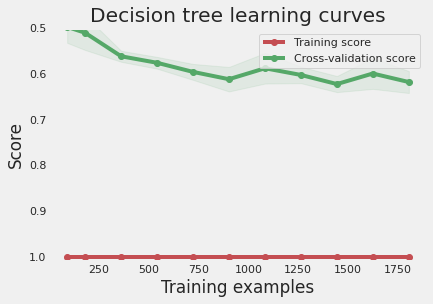

In [234]:
g = plot_learning_curve(tr.grid.best_estimator_, "Decision tree learning curves", X_train, Y_train,
                        ylim = [1.01, 0.5], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.5 Random Forest

In [235]:
rf = Class_Fit(clf = ensemble.RandomForestClassifier)
param_grid = {'criterion' : ['entropy', 'gini'], 'n_estimators' : [100, 125, 150],
               'max_features' :['sqrt', 'log2']}
rf.grid_search(parameters = param_grid, Kfold = 3)
rf.grid_fit(X = X_train, Y = Y_train)
rf.grid_predict(X_test, Y_test)
rf.grid.best_params_

Precision: 73.45 % 


{'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 150}

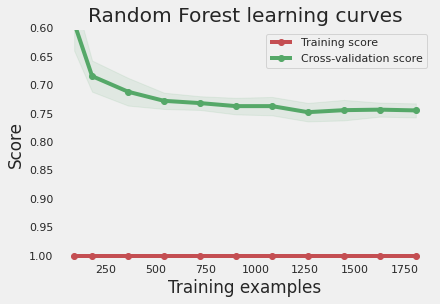

In [236]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest learning curves", X_train, Y_train,
                        ylim = [1.01, 0.6], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.6 AdaBoost Classifier

In [237]:
# from sklearn.tree import DecisionTreeClassifier
ada = Class_Fit(clf = AdaBoostClassifier)
# ada = Class_Fit(clf = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=3)))
param_grid = {'n_estimators' : [40,60,80]}
ada.grid_search(parameters = param_grid, Kfold = 3)
ada.grid_fit(X = X_train, Y = Y_train)
ada.grid_predict(X_test, Y_test)
ada.grid.best_params_

Precision: 59.12 % 


{'n_estimators': 40}

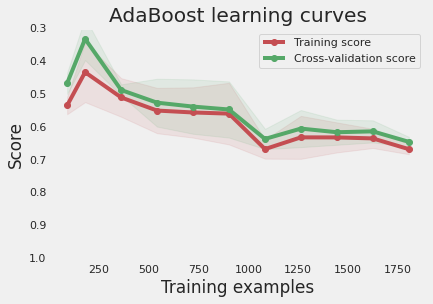

In [238]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost learning curves", X_train, Y_train,
                        ylim = [1.01, 0.3], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

### 5.7 Gradient Boosting Classifier

In [239]:
gb = Class_Fit(clf = ensemble.GradientBoostingClassifier)
param_grid = {'n_estimators' : [1000], 'max_depth' : [4]}
gb.grid_search(parameters = param_grid, Kfold = 3)
gb.grid_fit(X = X_train, Y = Y_train)
gb.grid_predict(X_test, Y_test)
gb.grid.best_params_

Precision: 70.27 % 


{'max_depth': 4, 'n_estimators': 1000}

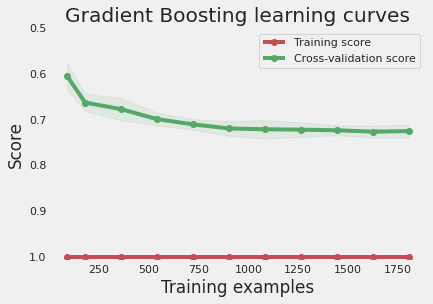

In [240]:
g = plot_learning_curve(gb.grid.best_estimator_, "Gradient Boosting learning curves", X_train, Y_train,
                        ylim = [1.01, 0.5], cv = 5, 
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

___
### 5.8 Let's vote !

Finally, the results of the different classifiers presented in the previous sections can be combined to improve the classification model. This can be achieved by selecting the customer category as the one indicated by the majority of classifiers. To do this, I use the `VotingClassifier` method of the `sklearn` package. As a first step, I adjust the parameters of the various classifiers using the *best* parameters previously found:

In [241]:
rf_best  = ensemble.RandomForestClassifier(**rf.grid.best_params_)
gb_best  = ensemble.GradientBoostingClassifier(**gb.grid.best_params_)
svc_best = svm.LinearSVC(**svc.grid.best_params_)
tr_best  = tree.DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = neighbors.KNeighborsClassifier(**knn.grid.best_params_)
lr_best  = linear_model.LogisticRegression(**lr.grid.best_params_)

Then, I define a classifier that merges the results of the various classifiers:

In [242]:
votingC = ensemble.VotingClassifier(estimators=[('rf', rf_best),('gb', gb_best),
                                                ('knn', knn_best)], voting='soft') 

and train it:

In [243]:
votingC = votingC.fit(X_train, Y_train)

Finally, we can create a prediction for this model:

In [244]:
predictions = votingC.predict(X_test)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test, predictions)))

Precision: 73.27 % 


Note that when defining the `votingC` classifier, I only used a sub-sample of the whole set of classifiers defined above and only retained the *Random Forest*, the *k-Nearest Neighbors* and the *Gradient Boosting* classifiers. In practice, this choice has been done with respect to the performance of the classification carried out in the next section.

___
## 6. Testing predictions

In the previous section, a few classifiers were trained in order to categorize customers. Until that point, the whole analysis was based on the data of the first 10 months. In this section, I test the model  the last two months of the dataset, that has been stored in the `set_test` dataframe:

In [245]:
basket_price_test = set_test.copy(deep = True)

In a first step, I regroup reformattes these data according to the same procedure as used on the training set. However, I am correcting the data to take into account the difference in time between the two datasets and weights the variables ** count ** and ** sum ** to obtain an equivalence with the training set:

In [246]:
transactions_per_user_test=basket_price_test.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user_test.loc[:,col] = basket_price_test.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user_test['sum']*100

transactions_per_user_test.reset_index(drop = False, inplace = True)
basket_price_test.groupby(by=['CustomerID'])['categ_0'].sum()

#_______________________
# Correcting time range
transactions_per_user_test['count'] = 5 * transactions_per_user_test['count']
transactions_per_user_test['sum']   = transactions_per_user_test['count'] * transactions_per_user_test['mean']

transactions_per_user_test.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347,10,224.82,1294.32,759.57,7595.70,24.271627,32.343299,5.035744,20.017905,12.696657
1,12349,5,1457.55,1457.55,1457.55,7287.75,12.918939,14.765874,10.325546,31.961854,5.442009
2,12352,5,231.73,231.73,231.73,1158.65,9.709576,11.750744,0.000000,46.303888,8.975963
3,12356,5,58.35,58.35,58.35,291.75,0.000000,0.000000,100.000000,0.000000,0.000000
4,12357,5,6207.67,6207.67,6207.67,31038.35,28.350089,14.684737,8.210810,18.475531,5.089832


Then, I convert the dataframe into a matrix and retain only variables that define the category to which consumers belong. At this level, I recall the method of normalization that had been used on the training set:

In [247]:
transactions_per_user_test.shape

(2550, 11)

In [248]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
matrix_test = transactions_per_user_test[list_cols]
matrix_test['dummy1'] =matrix_test['count']
matrix_test['dummy2'] =matrix_test['count']
matrix_test['dummy3'] =matrix_test['count']
matrix_test.head()

,count,min,max,mean,categ_0,categ_1,categ_2,categ_3,categ_4,dummy1,dummy2,dummy3
0,10,224.82,1294.32,759.57,24.271627,32.343299,5.035744,20.017905,12.696657,10,10,10
1,5,1457.55,1457.55,1457.55,12.918939,14.765874,10.325546,31.961854,5.442009,5,5,5
2,5,231.73,231.73,231.73,9.709576,11.750744,0.000000,46.303888,8.975963,5,5,5
3,5,58.35,58.35,58.35,0.000000,0.000000,100.000000,0.000000,0.000000,5,5,5
4,5,6207.67,6207.67,6207.67,28.350089,14.684737,8.210810,18.475531,5.089832,5,5,5


In [249]:
matrix_test.to_numpy()
scaled_test_matrix = scaler.transform(matrix_test)
matrix_test = matrix_test[list_cols]
matrix_test

,count,min,max,mean,categ_0,categ_1,categ_2,categ_3,categ_4
0,10,224.82,1294.32,759.570000,24.271627,32.343299,5.035744,20.017905,12.696657
1,5,1457.55,1457.55,1457.550000,12.918939,14.765874,10.325546,31.961854,5.442009
2,5,231.73,231.73,231.730000,9.709576,11.750744,0.000000,46.303888,8.975963
3,5,58.35,58.35,58.350000,0.000000,0.000000,100.000000,0.000000,0.000000
4,5,6207.67,6207.67,6207.670000,28.350089,14.684737,8.210810,18.475531,5.089832
...,...,...,...,...,...,...,...,...,...
2545,5,323.36,323.36,323.360000,10.112568,15.512123,30.616032,30.925285,12.833993
2546,5,110.38,110.38,110.380000,0.000000,11.415111,0.000000,30.186628,14.006161
2547,5,77.84,77.84,77.840000,38.026721,22.738952,32.759507,0.000000,6.474820
2548,30,1.95,307.05,159.783333,2.581621,49.126943,1.663711,29.828935,15.291541


Each line in this matrix contains a consumer's buying habits. At this stage, it is a question of using these habits in order to define the category to which the consumer belongs. These categories have been established in Section 4. ** At this stage, it is important to bear in mind that this step does not correspond to the classification stage itself**. Here, we prepare the test data by defining the category to which the customers belong. However, this definition uses data obtained over a period of 2 months (via the variables ** count **, ** min **, ** max ** and ** sum **). The classifier defined in Section 5 uses a more restricted set of variables that will be defined from the first purchase of a client.

Here it is a question of using the available data over a period of two months and using this data to define the category to which the customers belong. Then, the classifier can be tested by comparing its predictions with these categories. In order to define the category to which the clients belong, I recall the instance of the `kmeans` method used in section 4. The` predict` method of this instance calculates the distance of the consumers from the centroids of the 11 client classes and the smallest distance will define the belonging to the different categories:

In [250]:
Y = kmeans.predict(scaled_test_matrix)

Finally, in order to prepare the execution of the classifier, it is sufficient to select the variables on which it acts:

In [251]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transactions_per_user_test[columns]

It remains only to examine the predictions of the different classifiers that have been trained in section 5:

In [252]:
classifiers = [(svc, 'Support Vector Machine'),
                (lr, 'Logostic Regression'),
                (knn, 'k-Nearest Neighbors'),
                (tr, 'Decision Tree'),
                (rf, 'Random Forest'),
                (gb, 'Gradient Boosting')]
#______________________________
for clf, label in classifiers:
    print(30*'_', '\n{}'.format(label))
    clf.grid_predict(X, Y)

______________________________ 
Support Vector Machine
Precision: 39.29 % 
______________________________ 
Logostic Regression
Precision: 50.31 % 
______________________________ 
k-Nearest Neighbors
Precision: 47.18 % 
______________________________ 
Decision Tree
Precision: 46.08 % 
______________________________ 
Random Forest
Precision: 52.98 % 
______________________________ 
Gradient Boosting
Precision: 51.73 % 


Finally, as anticipated in Section 5.8, it is possible to improve the quality of the classifier by combining their respective predictions. At this level, I chose to mix *Random Forest*, *Gradient Boosting* and *k-Nearest Neighbors* predictions because this leads to a slight improvement in predictions:

In [253]:
predictions = votingC.predict(X)
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, predictions)))

Precision: 52.59 % 


___
## 7. Conclusion

The work described in this notebook is based on a database providing details on purchases made on an E-commerce platform over a period of one year. Each entry in the dataset describes the purchase of a product, by a particular customer and at a given date. In total, approximately $\sim$4000 clients appear in the database. Given the available information, I decided to develop a classifier that allows to anticipate the type of purchase that a customer will make, as well as the number of visits that he will make during a year, and this from its first visit to the E-commerce site.

The first stage of this work consisted in describing the different products sold by the site, which was the subject of a first classification. There, I grouped the different products into 5 main categories of goods. In a second step, I performed a classification of the customers by analyzing their consumption habits over a period of 10 months. I have classified clients into 11 major categories based on the type of products they usually buy, the number of visits they make and the amount they spent during the 10 months. Once these categories established, I finally trained several classifiers whose objective is to be able to classify consumers in one of these 11 categories and this from their first purchase. For this, the classifier is based on 5 variables which are:
- ** mean **: amount of the basket of the current purchase
- ** categ_N ** with $N \in [0: 4]$: percentage spent in product category with index $N$

Finally, the quality of the predictions of the different classifiers was tested over the last two months of the dataset. The data were then processed in two steps: first, all the data was considered (ober the 2 months) to define the category to which each client belongs, and then, the classifier predictions were compared with this category assignment. I then found that 75% of clients are awarded the right classes.
The performance of the classifier therefore seems correct given the potential shortcomings of the current model. In particular, a bias that has not been dealt with concerns the seasonality of purchases and the fact that purchasing habits will potentially depend on the time of year (for example, Christmas ). In practice, this seasonal effect may cause the categories defined over a 10-month period to be quite different from those extrapolated from the last two months. In order to correct such bias, it would be beneficial to have data that would cover a longer period of time.

In [254]:
stop_time = pd.datetime.now()
print('duration: ', stop_time - start_time)

duration:  0:31:23.526777
